# Notebook 4: LSTM model

**Objectives**:
- Implement and train LSTM models for our stock classification task
- Evaluate model performance using appropriate metrics
- Experiment with different hyperparameters
___
table of contents

## 1. Setup and Configuration

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import pickle
import os
import sys
sys.path.append('../utils')
import utils
from datetime import datetime
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input



# Set random seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("\n[OK] Libraries imported successfully")

TensorFlow version: 2.20.0
GPU Available: False

[OK] Libraries imported successfully


In [28]:
# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("[OK] Plotting configuration set")

[OK] Plotting configuration set


In [29]:
# Define paths
SEQUENCES_DIR = '../data_new/sequences/'
MODELS_DIR = '../models/lstm/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/lstm/'

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Assets and horizons
ASSETS = ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
HORIZONS = ['1day', '1week', '1month']

print("[OK] Directories configured")
print(f"  Assets: {ASSETS}")
print(f"  Horizons: {HORIZONS}")

[OK] Directories configured
  Assets: ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
  Horizons: ['1day', '1week', '1month']


In [30]:
# Load class weights
class_weights = utils.load_class_weights(SEQUENCES_DIR)

print("[OK] Data loading functions defined")
print(f"[OK] Class weights loaded for {len(class_weights)} combinations")

[OK] Data loading functions defined
[OK] Class weights loaded for 5 combinations


## 2. Single Model Training

Let's try to run a simple lstm model on an example to see how it performs initially.

## 2.1. APPL, 1day

In [31]:
# Load sample data
asset = 'AAPL'
horizon = '1day'

X_train, X_val, X_test, y_train, y_val, y_test, seq_len, n_feat = utils.load_sequences(asset, horizon)

print(f"Training LSTM on {asset} - {horizon}:")
print("="*80)
print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Sequence length: {seq_len}")
print(f"Features: {n_feat}")

Training LSTM on AAPL - 1day:
Train: 4405 samples
Val:   623 samples
Test:  1254 samples
Sequence length: 7
Features: 39


In [43]:
# Build model
model = utils.build_lstm_model(
    sequence_length=seq_len,
    n_features=n_feat,
    lstm_units=32,
    lstm_layers=1,
    dropout_rate=0.3,
    learning_rate=0.001
)

print("\nModel Architecture:")
print("="*80)
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")


Model Architecture:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 11,393


In [44]:
# Get class weights
cw = class_weights[asset][horizon]
class_weight_dict = {0: cw[0], 1: cw[1]}

print(f"Class weights: {class_weight_dict}")

# Train model
print("\nTraining model...")
print("="*80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=utils.get_callbacks(f'LSTM_{asset}_{horizon}'),
    verbose=1
)

print("\n[OK] Training complete!")

Class weights: {0: np.float64(1.0384252710985384), 1: np.float64(0.9643169877408057)}

Training model...
Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5076 - auc: 0.4998 - loss: 0.6998 - precision: 0.5238 - recall: 0.5918

138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5069 - auc: 0.5026 - loss: 0.6992 - precision: 0.5250 - recall: 0.5158 - val_accuracy: 0.4735 - val_auc: 0.4963 - val_loss: 0.7002 - val_precision: 0.5369 - val_recall: 0.3178 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5339 - auc: 0.5362 - loss: 0.6916 - precision: 0.5451 - recall: 0.6248

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5228 - auc: 0.5283 - loss: 0.6942 - precision: 0.5394 - recall: 0.5451 - val_accuracy: 0.4896 - val_auc: 0.5079 - val_loss: 0.6961 - val_precision: 0.5439 - val_recall: 0.4519 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5317 - auc: 0.5458 - loss: 0.6906 - precision: 0.5484 - recall: 0.5486 - val_accuracy: 0.4591 - val_auc: 0.4909 - val_loss: 0.7021 - val_precision: 0.5142 - val_recall: 0.3178 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5317 - auc: 0.5458 - loss: 0.6906 - precision: 0.5484 - recall: 0.5486 - val_accuracy: 0.4591 - val_auc: 0.4909 - val_loss: 0.7021 - val_precision: 0.5142 - val_recall: 0.3178 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5244 - auc: 0.5375 - loss: 0.6920 - precision: 0.5415 - recall: 0.5403 - val_accuracy: 0.4831 - val_auc: 0.4986 - val_loss: 0.6994 -

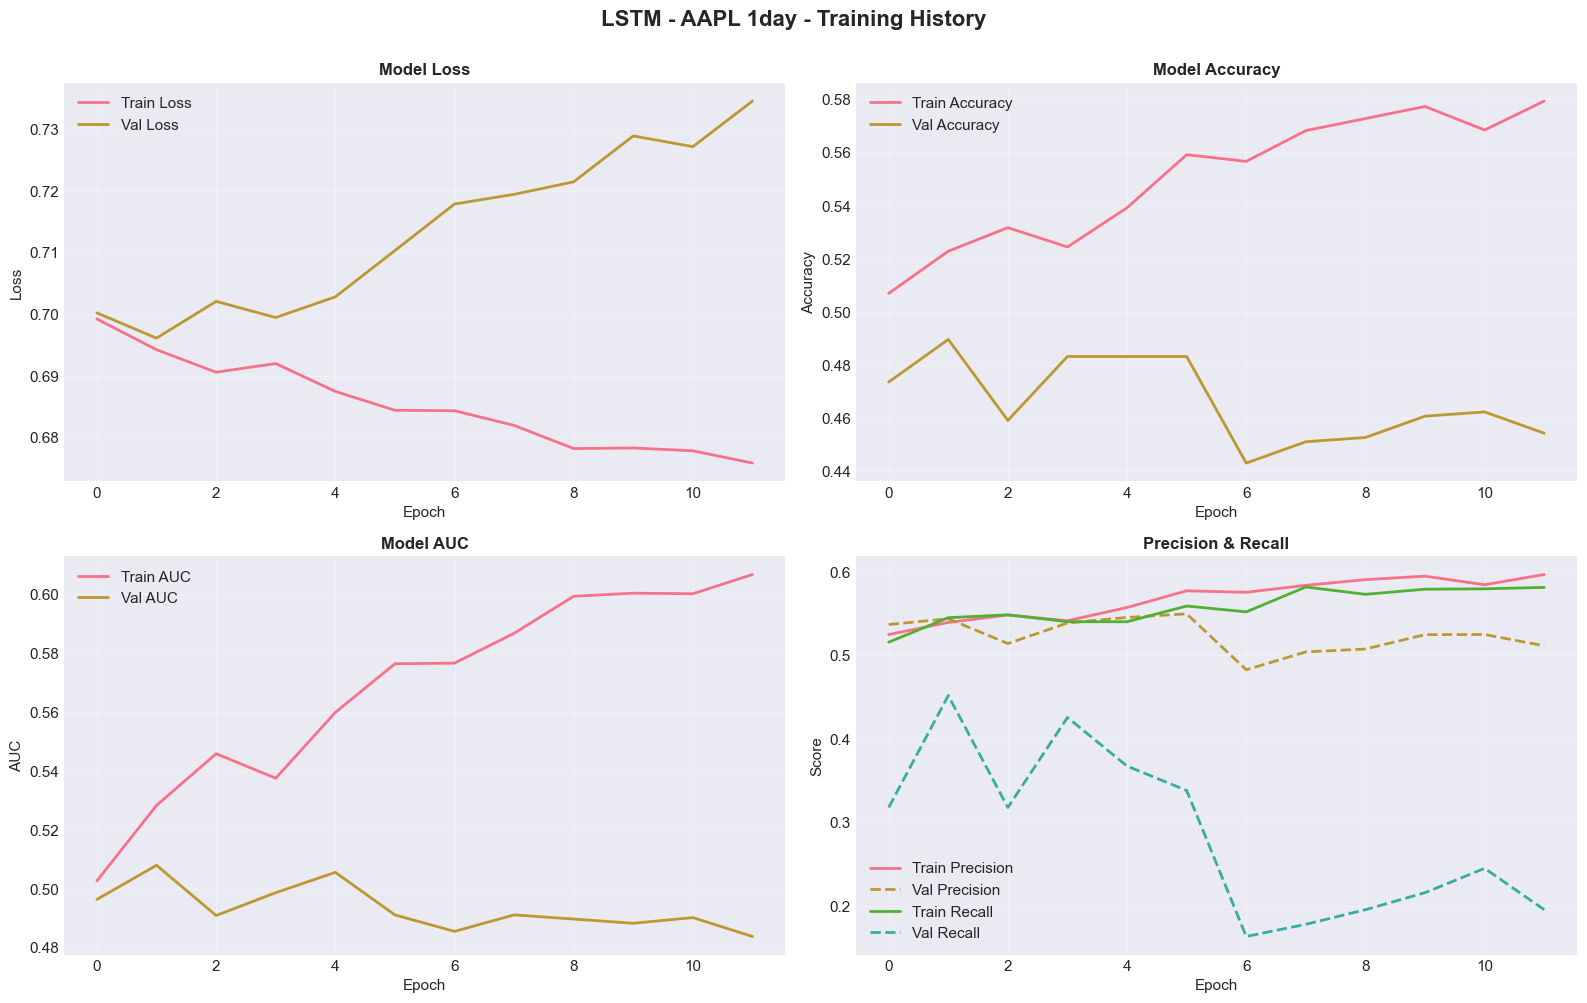

[OK] Training history saved


In [45]:
# Plot training history
utils.plot_training_history(
    history,
    f'LSTM - {asset} {horizon}',
    save_path=f'{FIGURES_DIR}LSTM_{asset}_{horizon}_training_history.png'
)

print("[OK] Training history saved")

In [35]:
# Evaluate on test set
print("Evaluating on test set...")
print("="*80)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print("Test Set Performance:")
for metric, value in test_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Evaluating on test set...
Test Set Performance:
  ACCURACY: 0.4888
  PRECISION: 0.5413
  RECALL: 0.2462
  F1: 0.3385
  ROC_AUC: 0.5171

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.47      0.76      0.58       588
          UP       0.54      0.25      0.34       666

    accuracy                           0.49      1254
   macro avg       0.51      0.50      0.46      1254
weighted avg       0.51      0.49      0.45      1254


Confusion Matrix:
[[449 139]
 [502 164]]


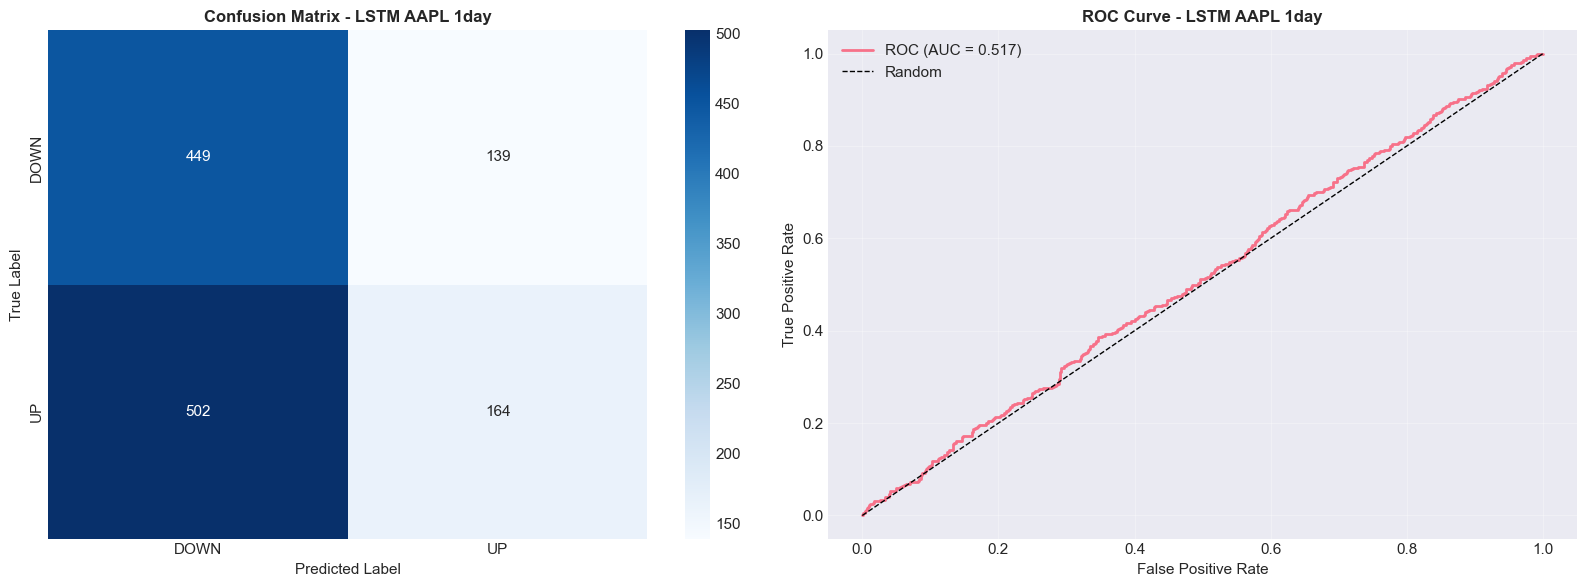

[OK] Evaluation visualizations saved


In [36]:
# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
axes[0].set_title(f'Confusion Matrix - LSTM {asset} {horizon}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_metrics["roc_auc"]:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_title(f'ROC Curve - LSTM {asset} {horizon}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}LSTM_{asset}_{horizon}_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Evaluation visualizations saved")

## 3. Hyperparameter Grid Search

The initial results show clear overfitting (AUC = 0.518). The model is really bad. Let's perform an **exhaustive grid search** to find optimal hyperparameters.

We'll test all 64 combinations (2×2×2×2×2×2) using nested loops to ensure we explore the entire search space systematically.

In [46]:
# Define hyperparameter search space (reduced for grid search)
param_grid = {
    'lstm_units': [32, 64],
    'lstm_layers': [1, 2],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [16, 32],
    'learning_rate': [0.0005, 0.001],
    'batch_size': [16, 32]
}

print("Hyperparameter Search Space:")
print("="*80)
for param, values in param_grid.items():
    print(f"  {param:20s}: {values}")
    
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")
print("Using exhaustive Grid Search - testing ALL combinations")

Hyperparameter Search Space:
  lstm_units          : [32, 64]
  lstm_layers         : [1, 2]
  dropout_rate        : [0.3, 0.5]
  dense_units         : [16, 32]
  learning_rate       : [0.0005, 0.001]
  batch_size          : [16, 32]

Total combinations: 64
Using exhaustive Grid Search - testing ALL combinations


In [47]:
# Grid search: test ALL combinations with nested loops
from itertools import product

search_results = []
total_combinations = np.prod([len(v) for v in param_grid.values()])

print("\n" + "="*80)
print(f"EXHAUSTIVE GRID SEARCH - {asset} {horizon}")
print("="*80)
print(f"Testing ALL {total_combinations} combinations...")
print()

# Create all combinations using itertools.product
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['lstm_layers'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['learning_rate'],
    param_grid['batch_size']
))

for iteration, (lstm_units, lstm_layers, dropout_rate, dense_units, learning_rate, batch_size) in enumerate(param_combinations, 1):
    params = {
        'lstm_units': lstm_units,
        'lstm_layers': lstm_layers,
        'dropout_rate': dropout_rate,
        'dense_units': dense_units,
        'learning_rate': learning_rate,
        'batch_size': batch_size
    }
    
    print(f"[{iteration}/{total_combinations}] Testing: " +
          f"units={lstm_units}, layers={lstm_layers}, " +
          f"dropout={dropout_rate}, lr={learning_rate}, " +
          f"batch={batch_size}")
    
    try:
        # Build model
        model_search = utils.build_lstm_model(
            sequence_length=seq_len,
            n_features=n_feat,
            lstm_units=lstm_units,
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate,
            dense_units=dense_units,
            learning_rate=learning_rate
        )
        
        # Train with early stopping
        history = model_search.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            callbacks=[
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    verbose=0
                )
            ],
            verbose=0
        )
        
        # Evaluate on validation set
        y_val_pred_proba = model_search.predict(X_val, verbose=0)
        y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()
        
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)
        val_f1 = f1_score(y_val, y_val_pred)
        
        # Store results
        result = {
            **params,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'epochs_trained': len(history.history['loss']),
            'final_val_loss': history.history['val_loss'][-1],
            'best_val_loss': min(history.history['val_loss'])
        }
        search_results.append(result)
        
        print(f"Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        continue

print("\n" + "="*80)
print("[OK] Grid search complete!")
print("="*80)


EXHAUSTIVE GRID SEARCH - AAPL 1day
Testing ALL 64 combinations...

[1/64] Testing: units=32, layers=1, dropout=0.3, lr=0.0005, batch=16
Val Accuracy: 0.5008, Val AUC: 0.5146, Val F1: 0.4893
[2/64] Testing: units=32, layers=1, dropout=0.3, lr=0.0005, batch=32
Val Accuracy: 0.5008, Val AUC: 0.5146, Val F1: 0.4893
[2/64] Testing: units=32, layers=1, dropout=0.3, lr=0.0005, batch=32
Val Accuracy: 0.5634, Val AUC: 0.5532, Val F1: 0.6634
[3/64] Testing: units=32, layers=1, dropout=0.3, lr=0.001, batch=16
Val Accuracy: 0.5634, Val AUC: 0.5532, Val F1: 0.6634
[3/64] Testing: units=32, layers=1, dropout=0.3, lr=0.001, batch=16
Val Accuracy: 0.4799, Val AUC: 0.4297, Val F1: 0.5803
[4/64] Testing: units=32, layers=1, dropout=0.3, lr=0.001, batch=32
Val Accuracy: 0.4799, Val AUC: 0.4297, Val F1: 0.5803
[4/64] Testing: units=32, layers=1, dropout=0.3, lr=0.001, batch=32
Val Accuracy: 0.4623, Val AUC: 0.4750, Val F1: 0.3986
[5/64] Testing: units=32, layers=1, dropout=0.3, lr=0.0005, batch=16
Val Ac

In [48]:
# Analyze search results
search_df = pd.DataFrame(search_results)

print("\nTop 10 Configurations by Validation AUC:")
print("="*120)
top_10 = search_df.nlargest(10, 'val_auc')
print(top_10[['lstm_units', 'lstm_layers', 'dropout_rate', 'learning_rate', 
              'batch_size', 'val_accuracy', 'val_auc', 'val_f1']].to_string(index=False))

print("\n" + "="*80)
print("BEST CONFIGURATION:")
print("="*80)
best_idx = search_df['val_auc'].idxmax()
best_params = search_df.iloc[best_idx]

for param in ['lstm_units', 'lstm_layers', 'dropout_rate', 'dense_units', 'learning_rate', 'batch_size']:
    print(f"  {param:20s}: {best_params[param]}")

print(f"\nValidation Performance:")
print(f"  Accuracy: {best_params['val_accuracy']:.4f}")
print(f"  AUC:      {best_params['val_auc']:.4f}")
print(f"  F1:       {best_params['val_f1']:.4f}")


Top 10 Configurations by Validation AUC:
 lstm_units  lstm_layers  dropout_rate  learning_rate  batch_size  val_accuracy  val_auc   val_f1
         32            1           0.3         0.0005          32      0.563403 0.553243 0.663366
         32            1           0.5         0.0010          16      0.542536 0.545544 0.611187
         64            2           0.5         0.0005          32      0.555377 0.539254 0.650694
         32            2           0.5         0.0010          16      0.497592 0.537823 0.473950
         32            1           0.3         0.0005          32      0.547352 0.537203 0.628947
         64            2           0.3         0.0005          16      0.518459 0.536787 0.482759
         32            1           0.5         0.0005          16      0.499197 0.536672 0.436823
         64            1           0.5         0.0005          16      0.532905 0.533590 0.599725
         32            1           0.5         0.0010          32      0.540

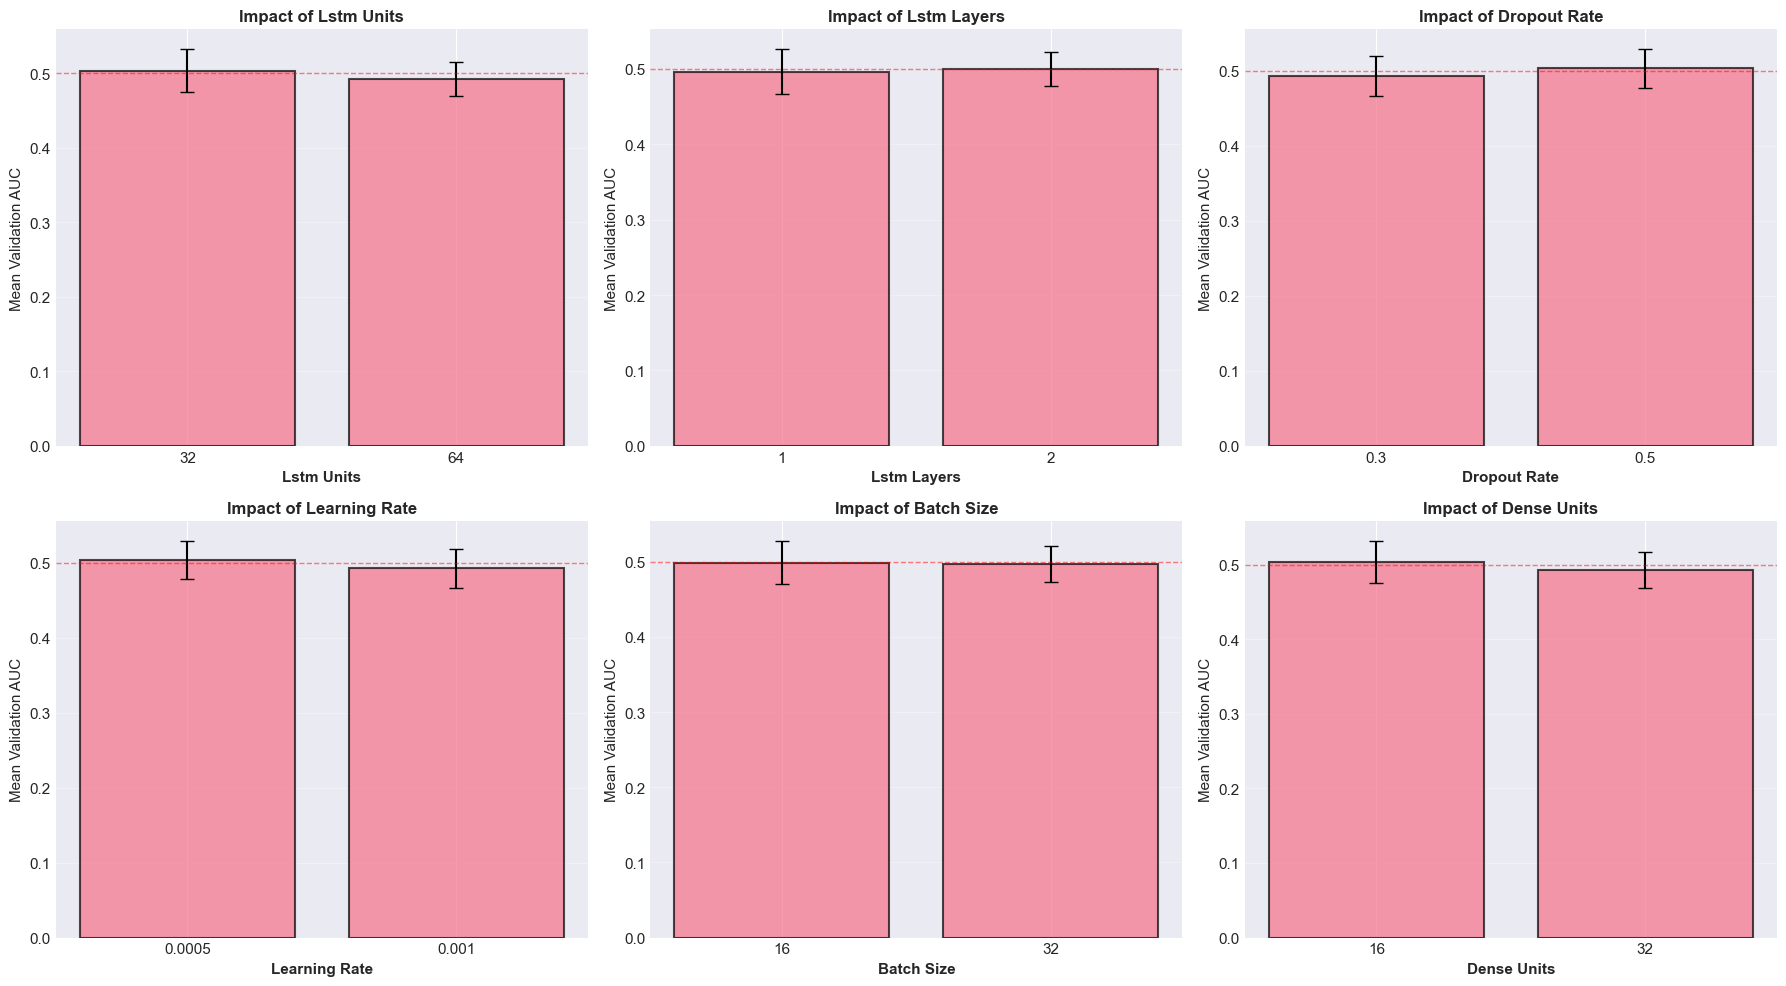

[OK] Hyperparameter analysis visualization saved


In [49]:
# Visualize hyperparameter importance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

params_to_plot = ['lstm_units', 'lstm_layers', 'dropout_rate', 'learning_rate', 'batch_size', 'dense_units']

for idx, param in enumerate(params_to_plot):
    ax = axes[idx]
    
    # Group by parameter and calculate mean AUC
    grouped = search_df.groupby(param)['val_auc'].agg(['mean', 'std', 'count'])
    
    ax.bar(grouped.index.astype(str), grouped['mean'], yerr=grouped['std'], 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(param.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Validation AUC', fontsize=11)
    ax.set_title(f'Impact of {param.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}hyperparameter_search_{asset}_{horizon}.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Hyperparameter analysis visualization saved")

In [50]:
# Retrain best model and evaluate on test set
print("\n" + "="*80)
print("RETRAINING WITH BEST HYPERPARAMETERS")
print("="*80)

best_model = utils.build_lstm_model(
    sequence_length=seq_len,
    n_features=n_feat,
    lstm_units=int(best_params['lstm_units']),
    lstm_layers=int(best_params['lstm_layers']),
    dropout_rate=float(best_params['dropout_rate']),
    dense_units=int(best_params['dense_units']),
    learning_rate=float(best_params['learning_rate'])
)

print("\nBest Model Architecture:")
best_model.summary()

# Train with best parameters
history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=int(best_params['batch_size']),
    class_weight=class_weight_dict,
    callbacks=utils.get_callbacks(f'LSTM_{asset}_{horizon}_best', patience=15),
    verbose=1
)

print("\n[OK] Best model training complete!")


RETRAINING WITH BEST HYPERPARAMETERS

Best Model Architecture:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,761 (38.13 KB)

 Trainable params: 9,761 (38.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4986 - auc: 0.4999 - loss: 0.7091 - precision: 0.5195 - recall: 0.4928

138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5001 - auc: 0.4996 - loss: 0.7080 - precision: 0.5191 - recall: 0.4886 - val_accuracy: 0.4960 - val_auc: 0.4840 - val_loss: 0.7006 - val_precision: 0.5428 - val_recall: 0.5364 - learning_rate: 5.0000e-04
Epoch 2/100
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5249 - auc: 0.5306 - loss: 0.6957 - precision: 0.5445 - recall: 0.5118 - val_accuracy: 0.4960 - val_auc: 0.4808 - val_loss: 0.7032 - val_precision: 0.5607 - val_recall: 0.3907 - learning_rate: 5.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5249 - auc: 0.5306 - loss: 0.6957 - precision: 0.5445 - recall: 0.5118 - val_accuracy: 0.4960 - val_auc: 0.4808 - val_loss: 0.7032 - val_precision: 0.5607 - val_recall: 0.3907 - learning_rate: 5.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5076 - auc: 0.5132 - loss: 0.6982 - precision: 0.5255 - recall: 0.5180 - val_accuracy: 0.4799 - val_auc: 0.4861 - val_l


Evaluating best model on test set...

Best Model - Test Set Performance:
  ACCURACY: 0.4785
  PRECISION: 0.5098
  RECALL: 0.4685
  F1: 0.4883
  ROC_AUC: 0.4882

Comparison with Initial Model:
  Initial AUC: 0.5171
  Best AUC:    0.4882
  Improvement: -0.0289

Best Model - Test Set Performance:
  ACCURACY: 0.4785
  PRECISION: 0.5098
  RECALL: 0.4685
  F1: 0.4883
  ROC_AUC: 0.4882

Comparison with Initial Model:
  Initial AUC: 0.5171
  Best AUC:    0.4882
  Improvement: -0.0289


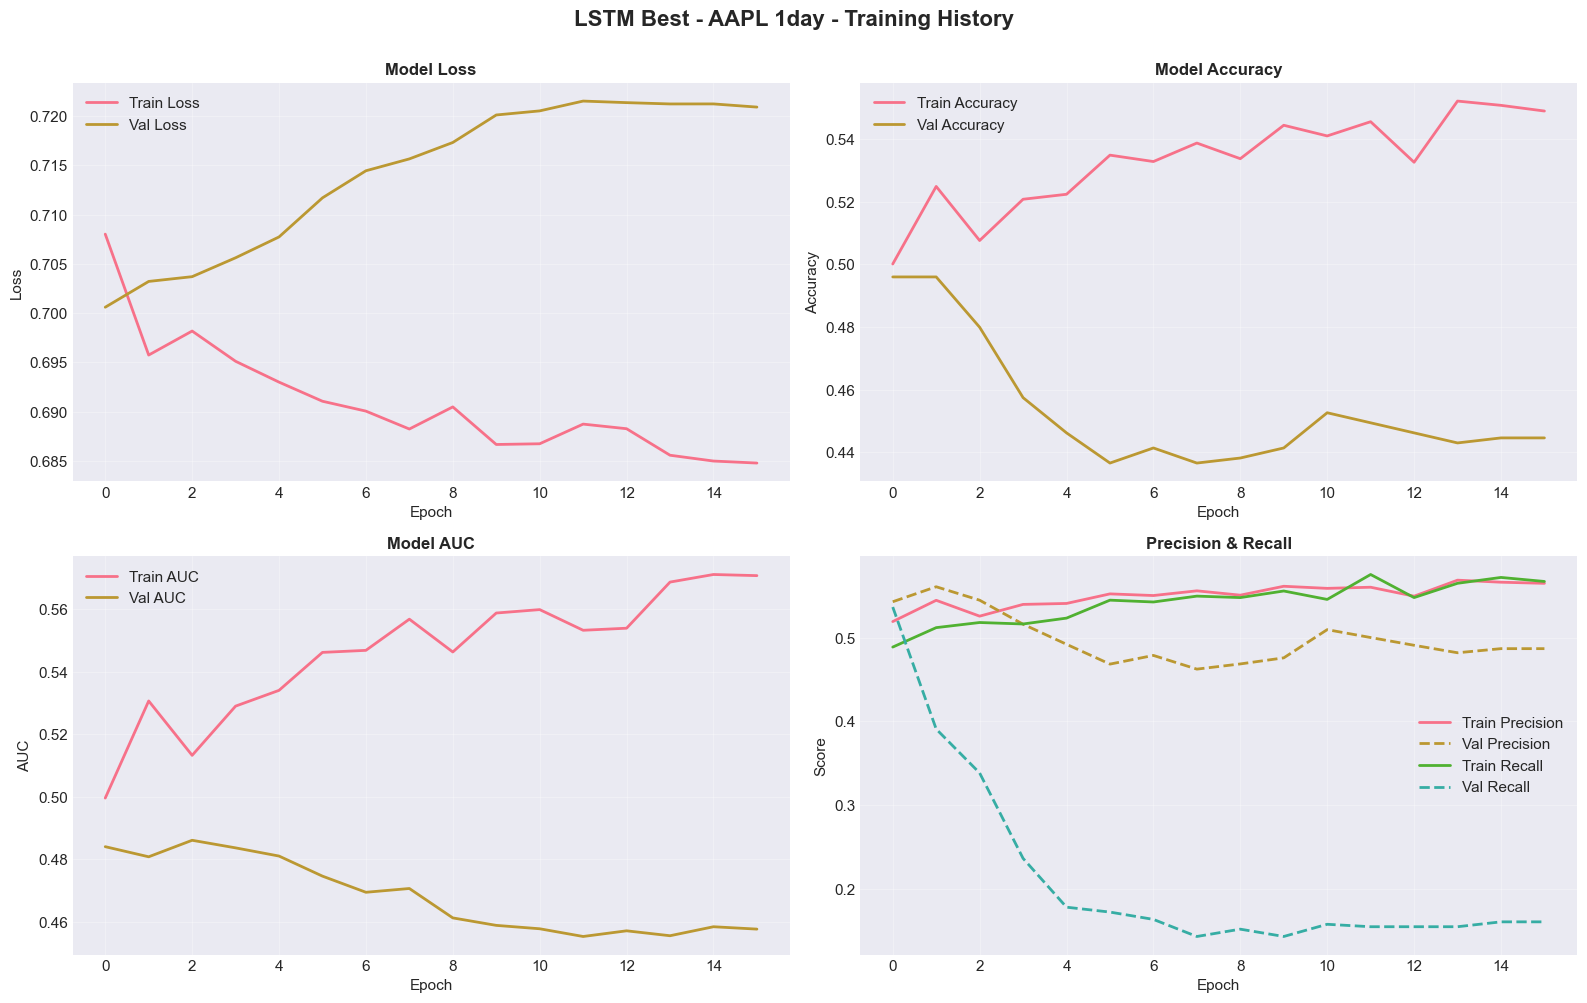

In [51]:
# Evaluate best model on test set
print("\nEvaluating best model on test set...")
print("="*80)

y_test_pred_proba = best_model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

test_metrics_best = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_pred_proba)
}

print("\nBest Model - Test Set Performance:")
for metric, value in test_metrics_best.items():
    print(f"  {metric.upper()}: {value:.4f}")

print("\nComparison with Initial Model:")
print(f"  Initial AUC: {test_metrics['roc_auc']:.4f}")
print(f"  Best AUC:    {test_metrics_best['roc_auc']:.4f}")
print(f"  Improvement: {(test_metrics_best['roc_auc'] - test_metrics['roc_auc']):.4f}")

# Plot training history for best model
utils.plot_training_history(
    history_best,
    f'LSTM Best - {asset} {horizon}',
    save_path=f'{FIGURES_DIR}LSTM_{asset}_{horizon}_best_history.png'
)

**Remarks on Hyperparameter Search Results:**

The grid search helps us understand if better hyperparameters exist, but there are important considerations:

1. **Financial prediction is inherently difficult** - Daily stock movements are largely random. Even with optimal hyperparameters, we may only achieve AUC around 0.52-0.55 (vs 0.50 random baseline).

2. **Key insights from the search**:
   - If all configurations perform similarly (AUC ~0.51-0.53), the problem may be too noisy for deep learning
   - If we find significantly better configurations (AUC >0.55), those parameters should be used
   - Patterns in hyperparameter importance reveal what matters most for this data

3. **Next steps**:
   - If results remain poor, consider longer prediction horizons (1week, 1month) which have stronger trends
   - Try feature selection to reduce noise
   - Consider ensemble methods or different architectures (GRU, CNN, Transformer)

## 2.2. Complete Training Loop: All Assets and Horizons

Train LSTM models for all 16 combinations (4 assets x 4 horizons).

Starting complete LSTM training...

Training: AAPL - 1day
Data loaded: Train=4405, Val=623, Test=1254



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

[OK] Completed in 51.9s
  Accuracy: 0.5120
  F1 Score: 0.5204
  AUC: 0.5176

[OK] Completed in 51.9s
  Accuracy: 0.5120
  F1 Score: 0.5204
  AUC: 0.5176


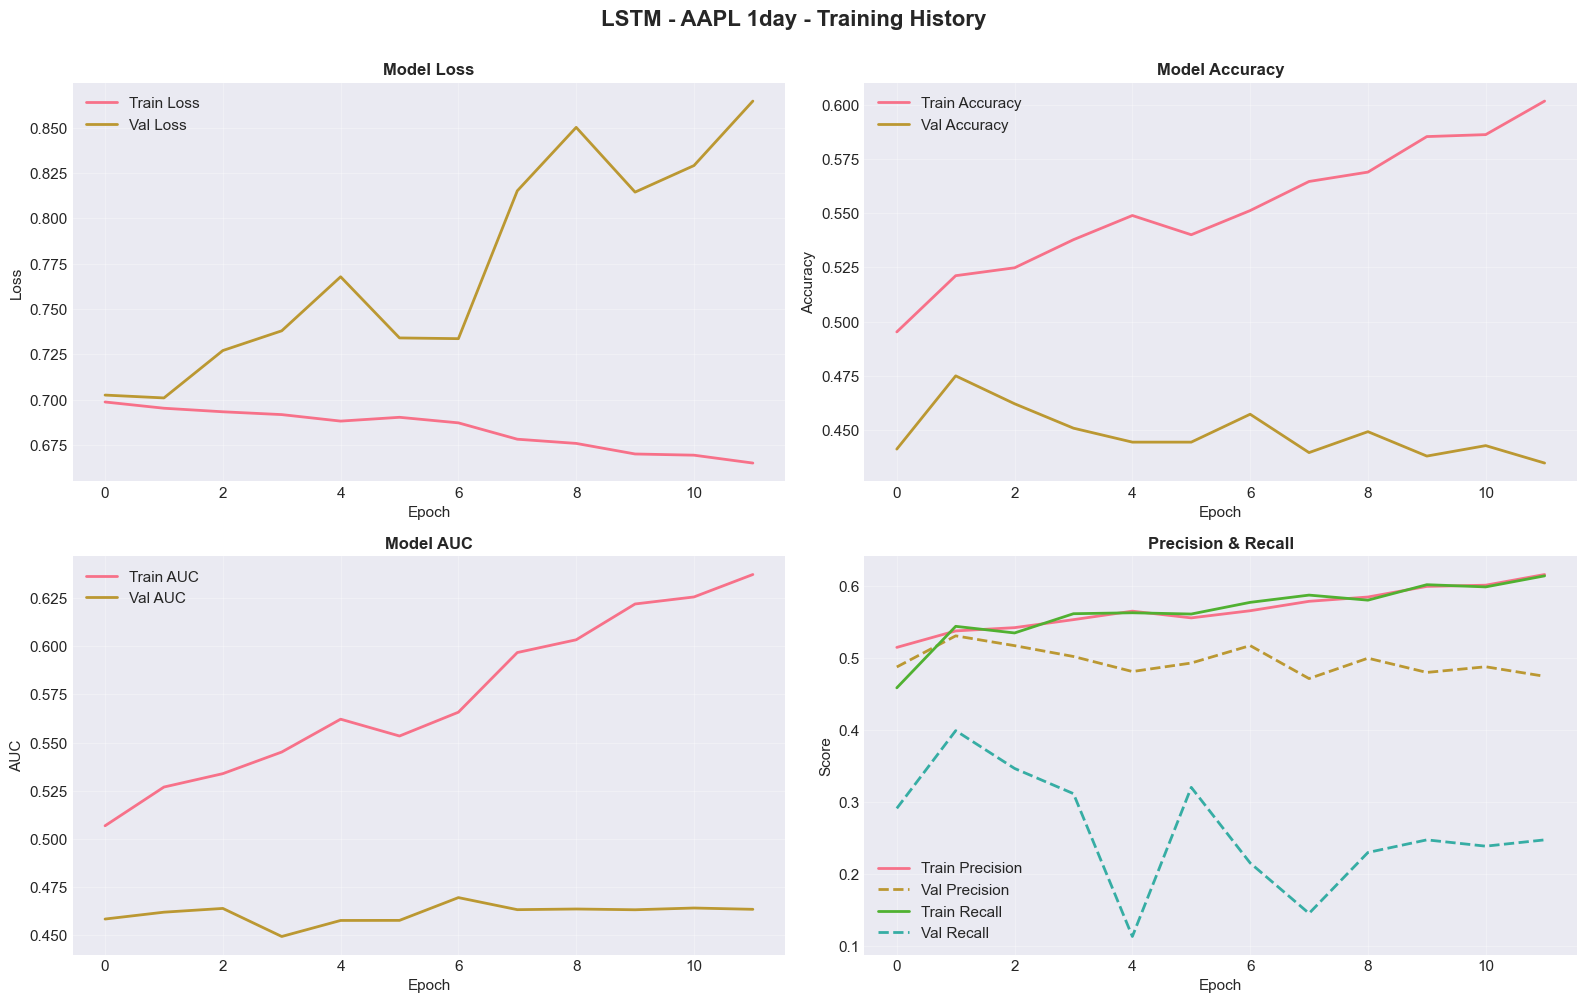


Training: AAPL - 1week
Data loaded: Train=4382, Val=600, Test=1231



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 61.1s
  Accuracy: 0.4809
  F1 Score: 0.3766
  AUC: 0.4975

[OK] Completed in 61.1s
  Accuracy: 0.4809
  F1 Score: 0.3766
  AUC: 0.4975


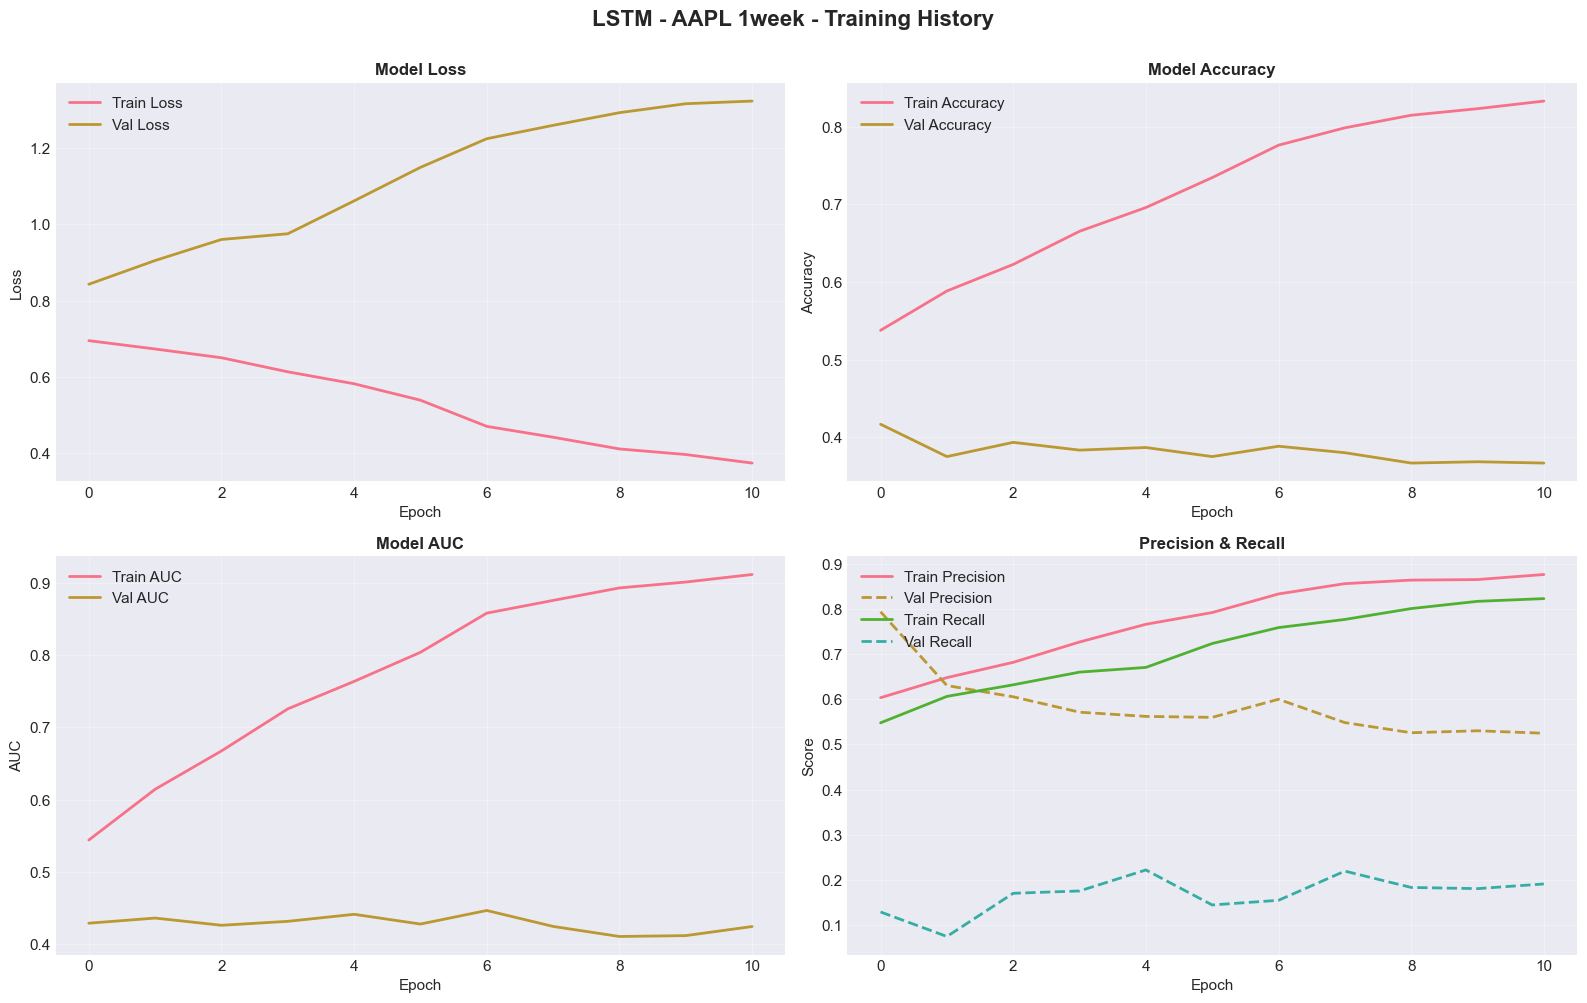


Training: AAPL - 1month
Data loaded: Train=4322, Val=540, Test=1171



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 132.5s
  Accuracy: 0.3809
  F1 Score: 0.0423
  AUC: 0.4896

[OK] Completed in 132.5s
  Accuracy: 0.3809
  F1 Score: 0.0423
  AUC: 0.4896


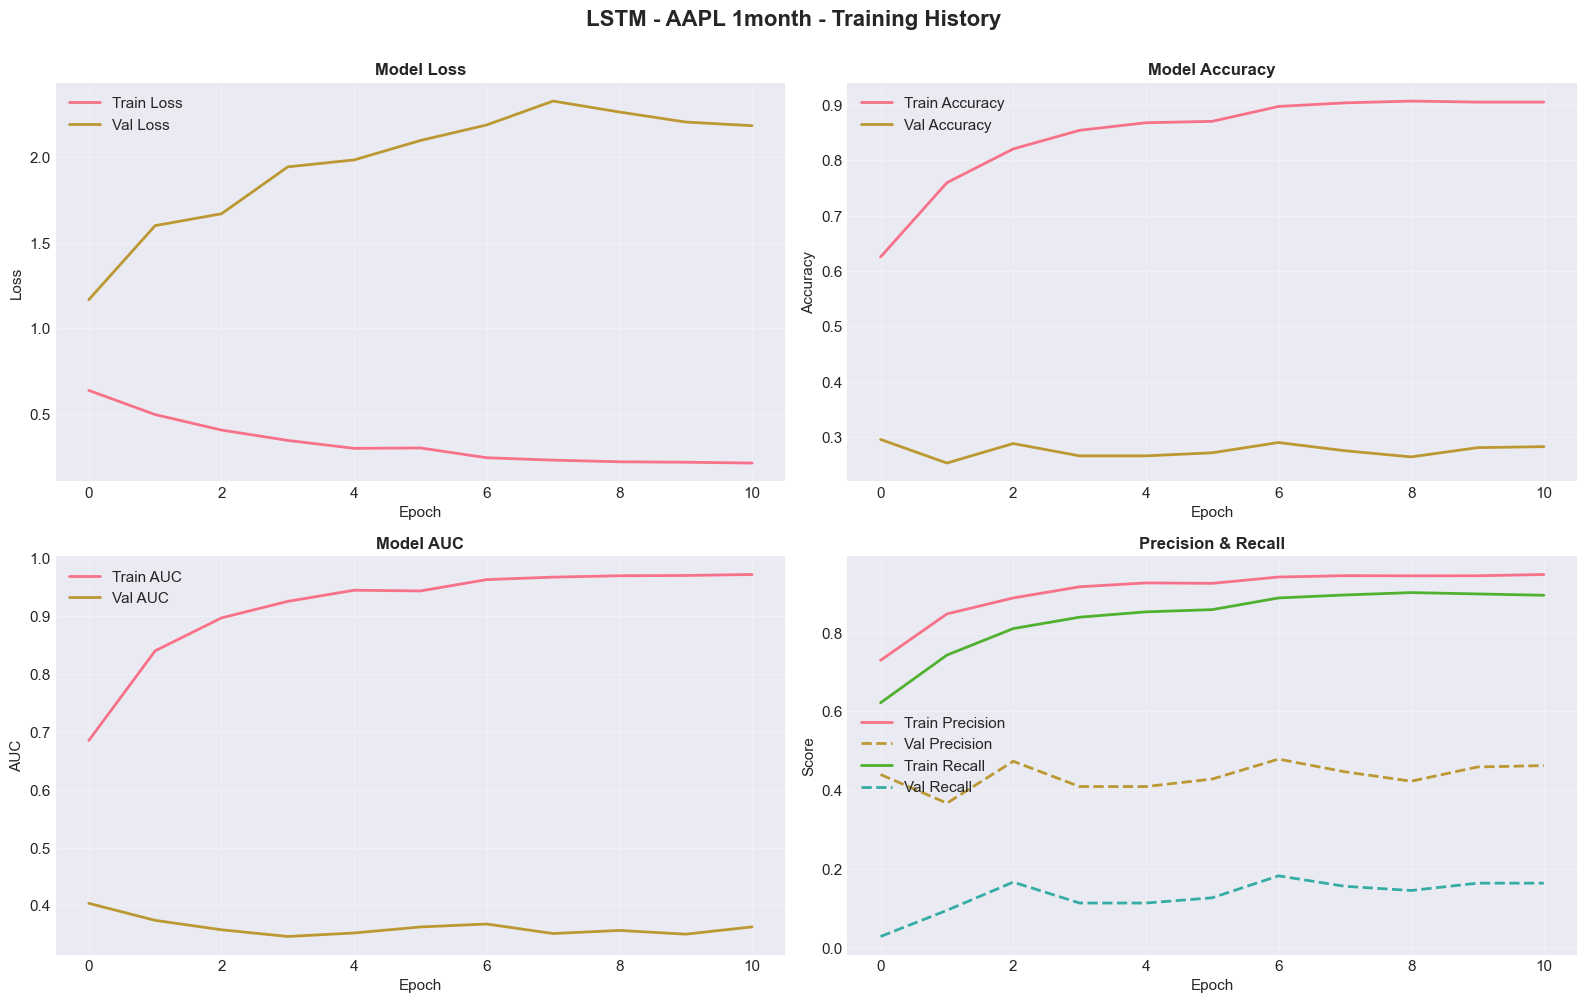


Training: AMZN - 1day
Data loaded: Train=4405, Val=623, Test=1254



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 22.2s
  Accuracy: 0.5175
  F1 Score: 0.6801
  AUC: 0.5287

[OK] Completed in 22.2s
  Accuracy: 0.5175
  F1 Score: 0.6801
  AUC: 0.5287


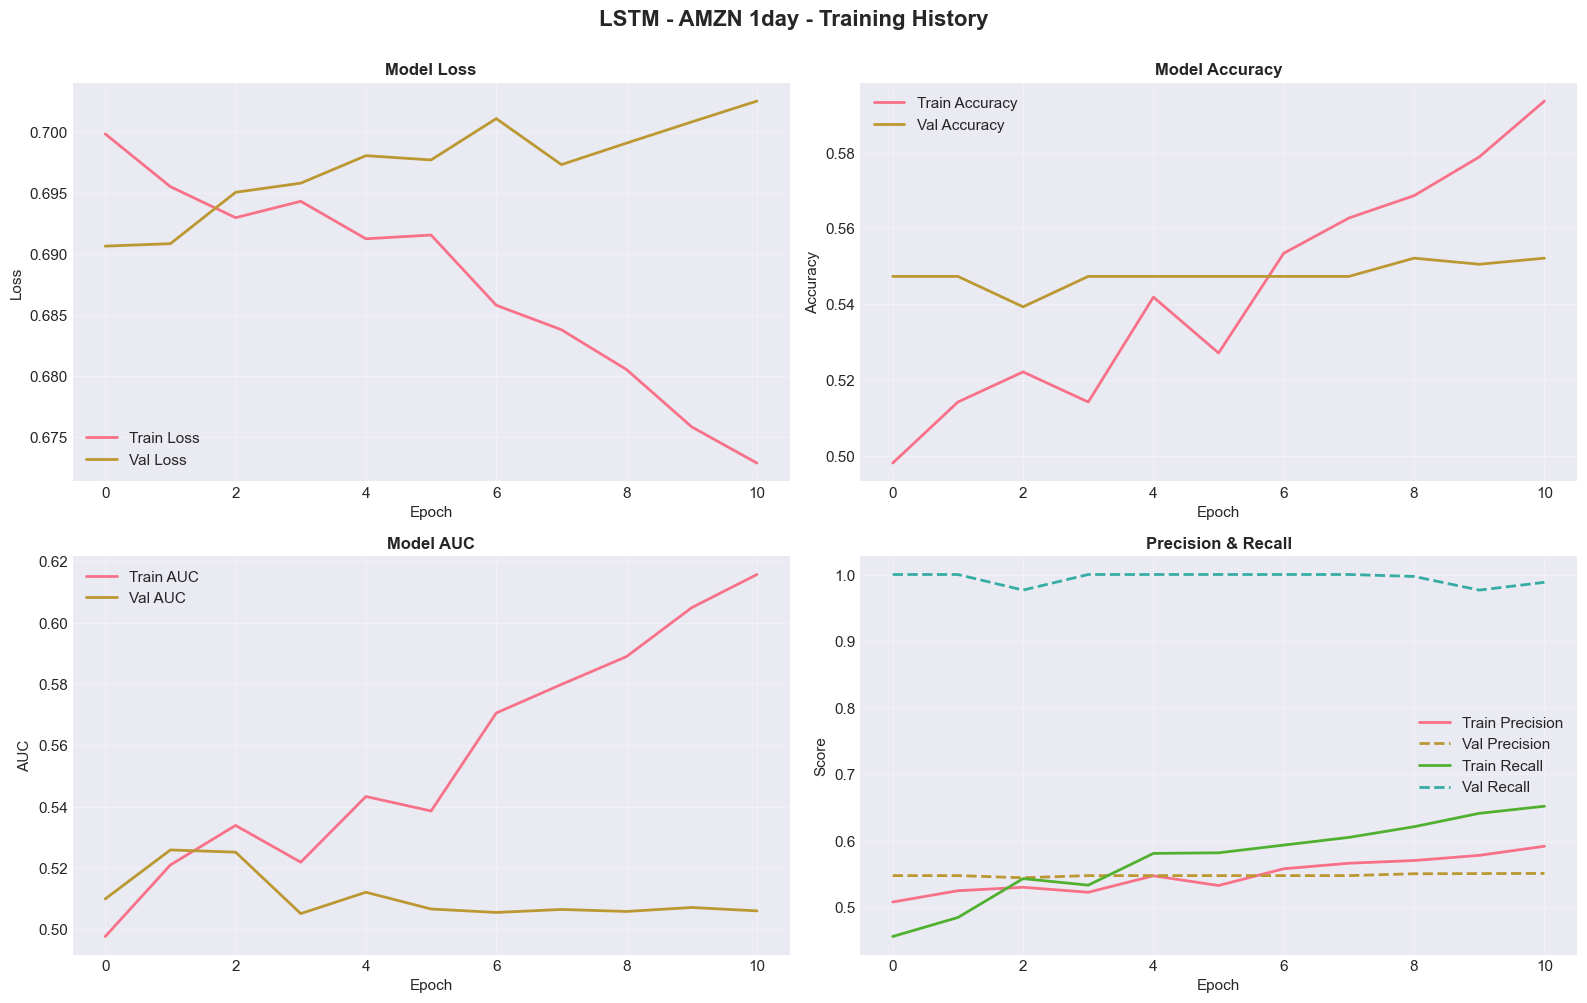


Training: AMZN - 1week
Data loaded: Train=4382, Val=600, Test=1231



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

[OK] Completed in 70.0s
  Accuracy: 0.5337
  F1 Score: 0.6960
  AUC: 0.5200

[OK] Completed in 70.0s
  Accuracy: 0.5337
  F1 Score: 0.6960
  AUC: 0.5200


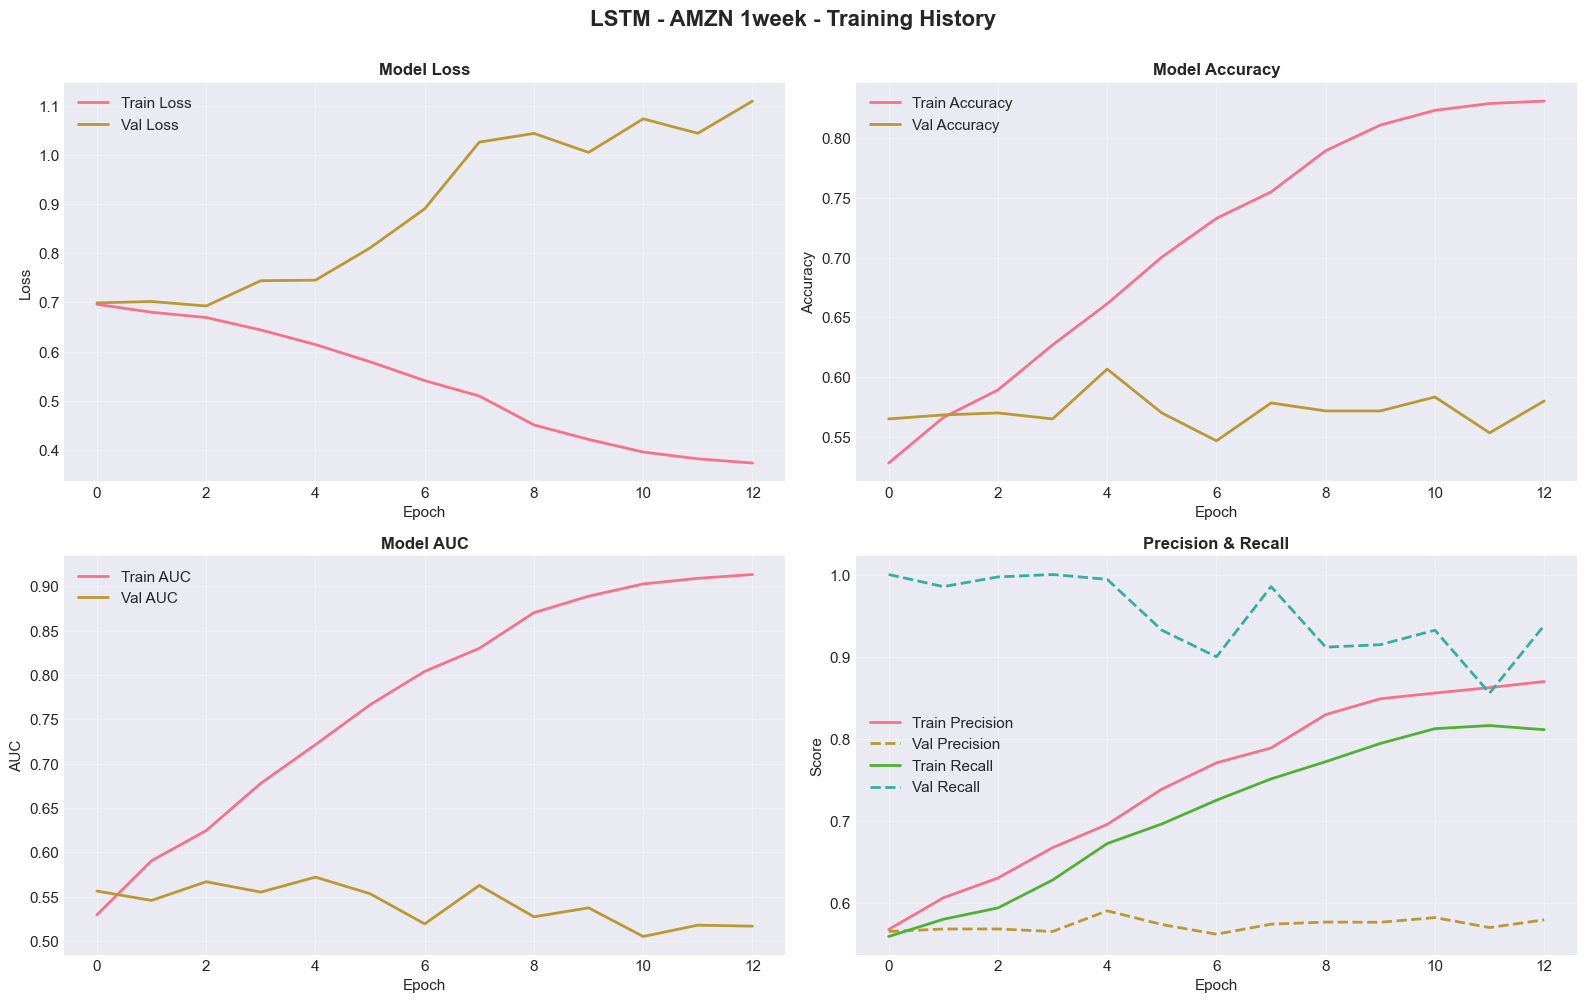


Training: AMZN - 1month
Data loaded: Train=4322, Val=540, Test=1171
Data loaded: Train=4322, Val=540, Test=1171



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 143.3s
  Accuracy: 0.5201
  F1 Score: 0.6198
  AUC: 0.4785

[OK] Completed in 143.3s
  Accuracy: 0.5201
  F1 Score: 0.6198
  AUC: 0.4785


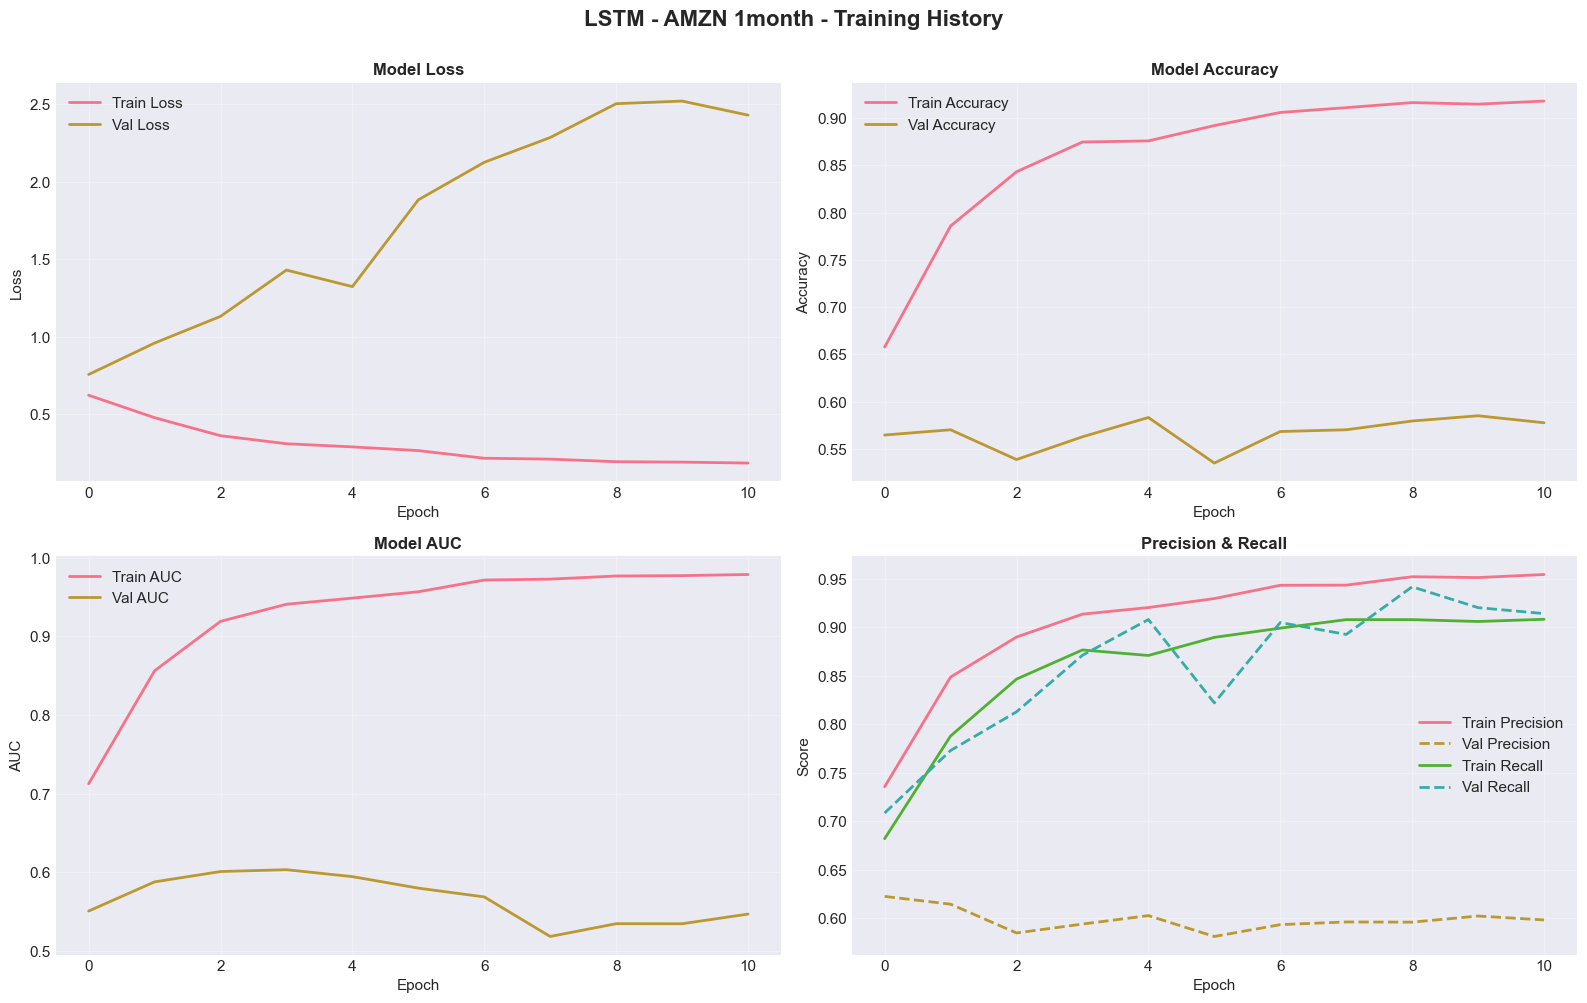


Training: NVDA - 1day
Data loaded: Train=4405, Val=623, Test=1254



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.

[OK] Completed in 91.7s
  Accuracy: 0.4785
  F1 Score: 0.4801
  AUC: 0.4792

[OK] Completed in 91.7s
  Accuracy: 0.4785
  F1 Score: 0.4801
  AUC: 0.4792


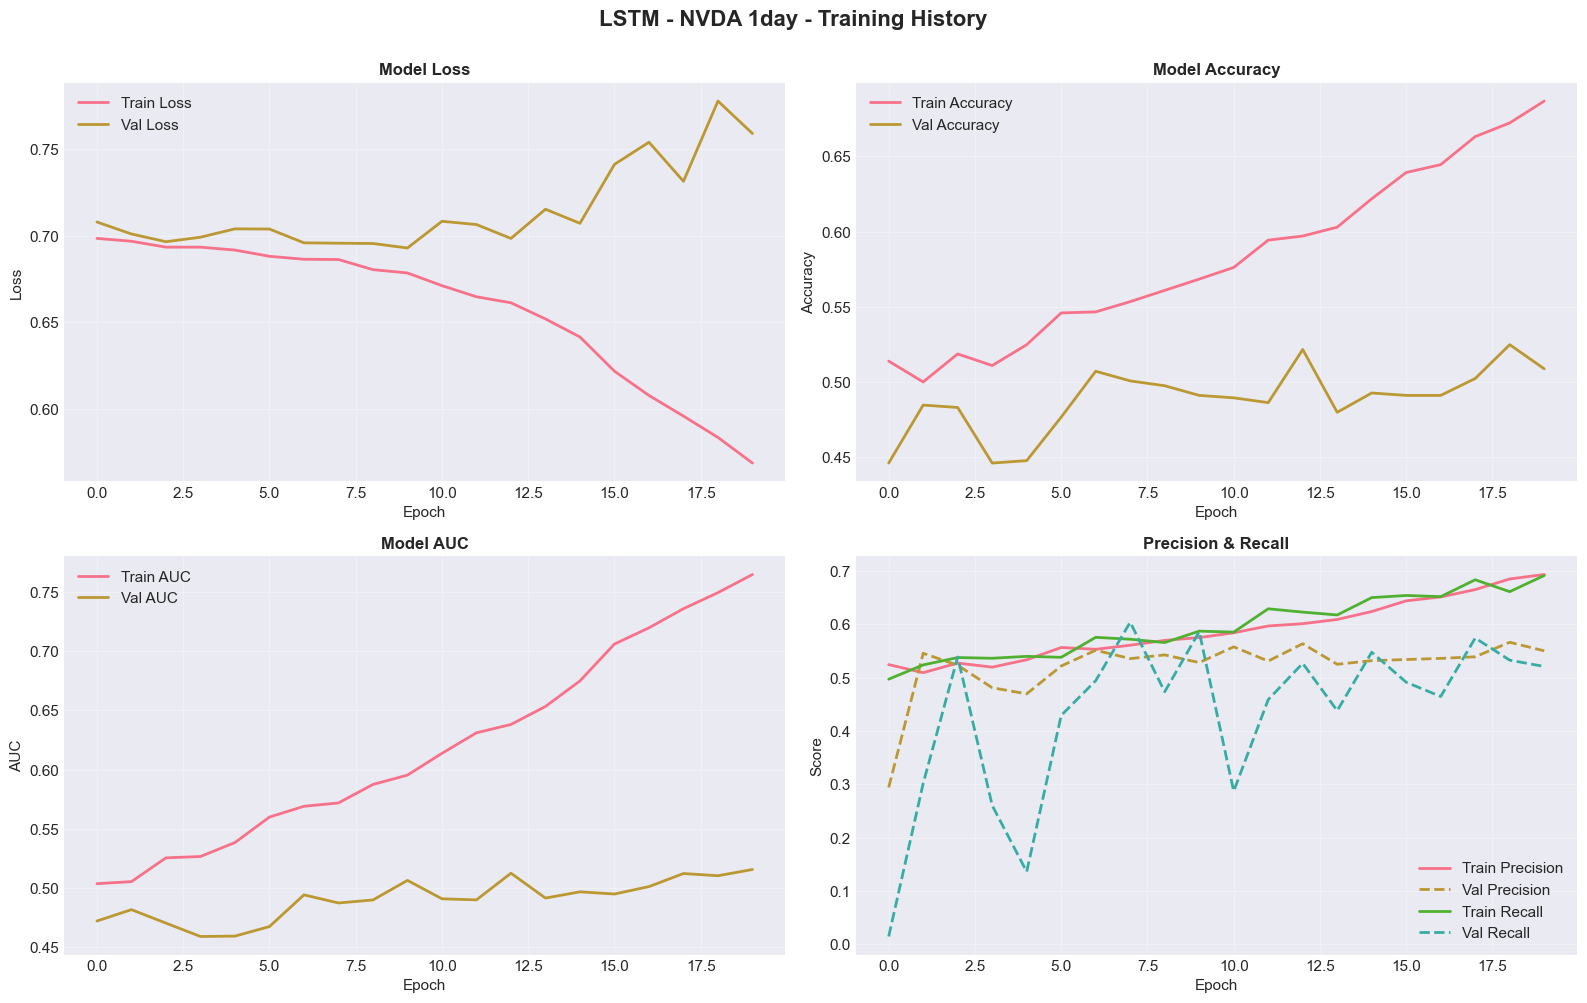


Training: NVDA - 1week
Data loaded: Train=4382, Val=600, Test=1231
Data loaded: Train=4382, Val=600, Test=1231



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 115.2s
  Accuracy: 0.5841
  F1 Score: 0.7374
  AUC: 0.4601

[OK] Completed in 115.2s
  Accuracy: 0.5841
  F1 Score: 0.7374
  AUC: 0.4601


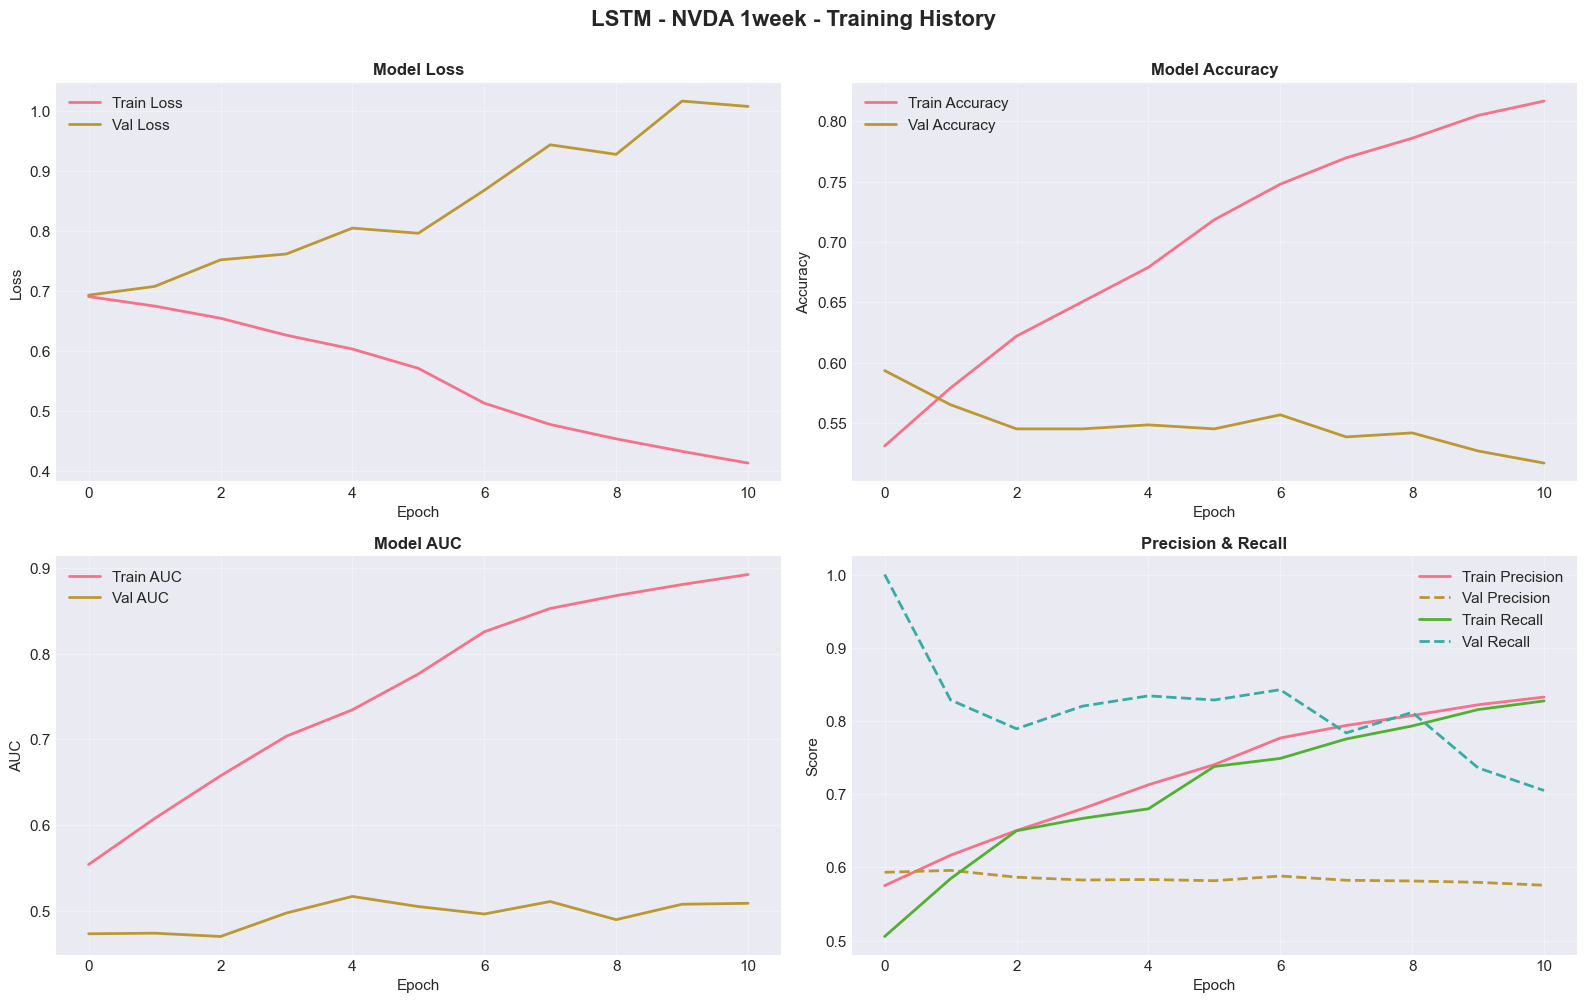


Training: NVDA - 1month
Data loaded: Train=4322, Val=540, Test=1171
Data loaded: Train=4322, Val=540, Test=1171



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 221.4s
  Accuracy: 0.4893
  F1 Score: 0.5685
  AUC: 0.4368

[OK] Completed in 221.4s
  Accuracy: 0.4893
  F1 Score: 0.5685
  AUC: 0.4368


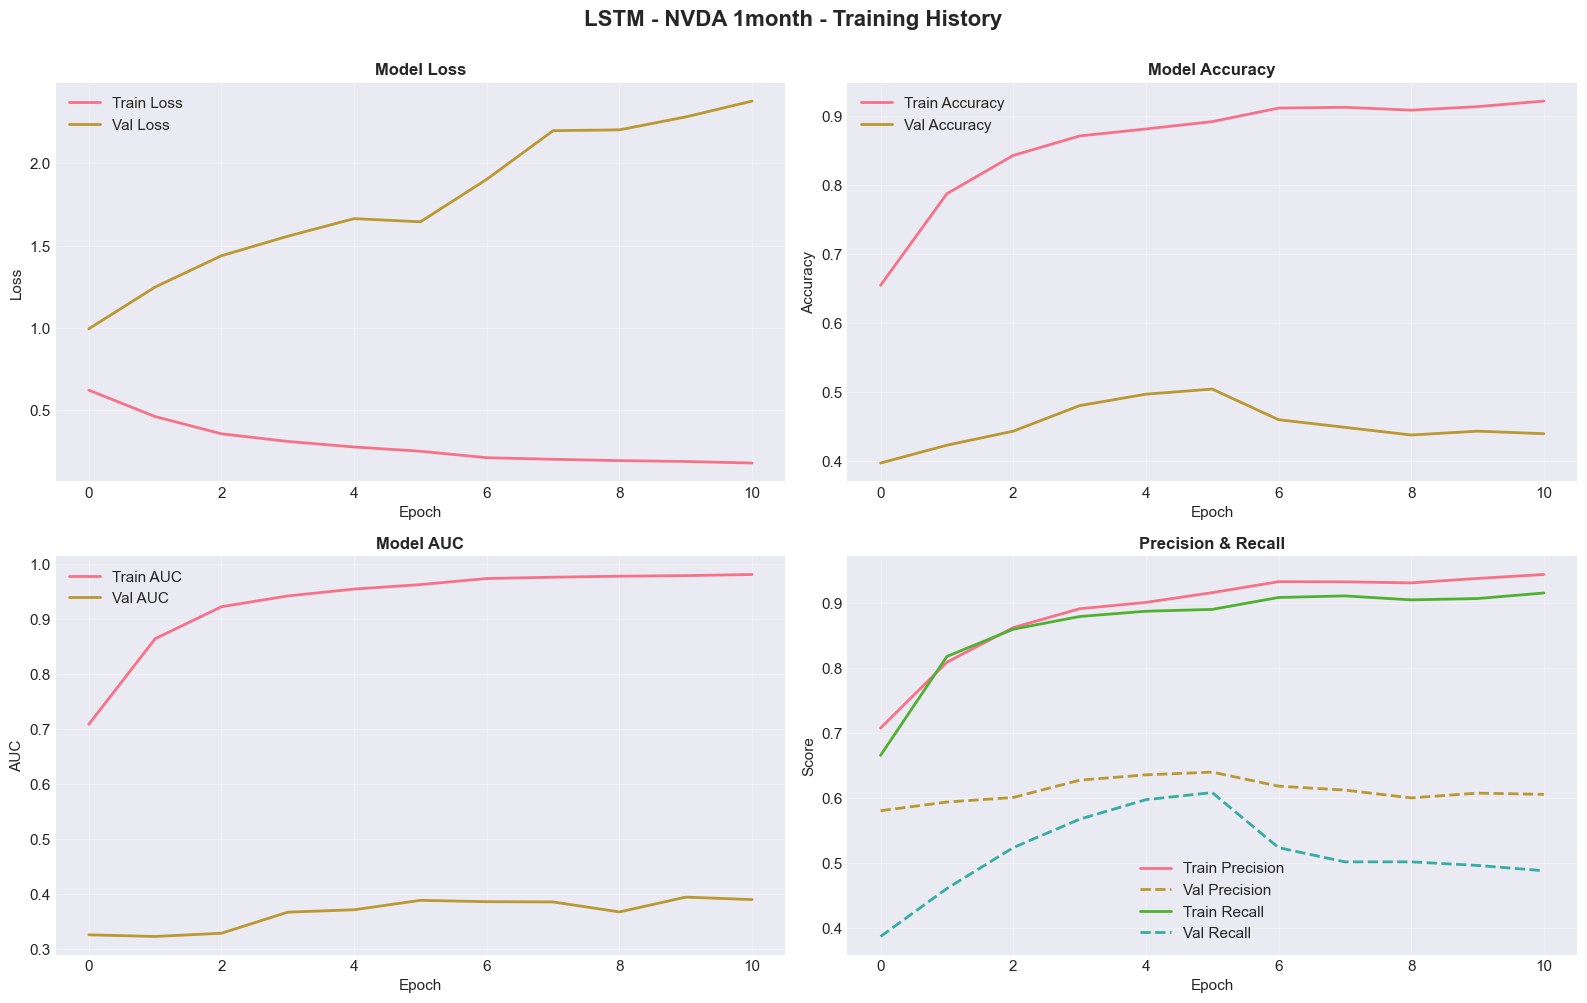


Training: SPY - 1day
Data loaded: Train=4405, Val=623, Test=1254



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

[OK] Completed in 59.3s
  Accuracy: 0.4880
  F1 Score: 0.4216
  AUC: 0.4929

[OK] Completed in 59.3s
  Accuracy: 0.4880
  F1 Score: 0.4216
  AUC: 0.4929


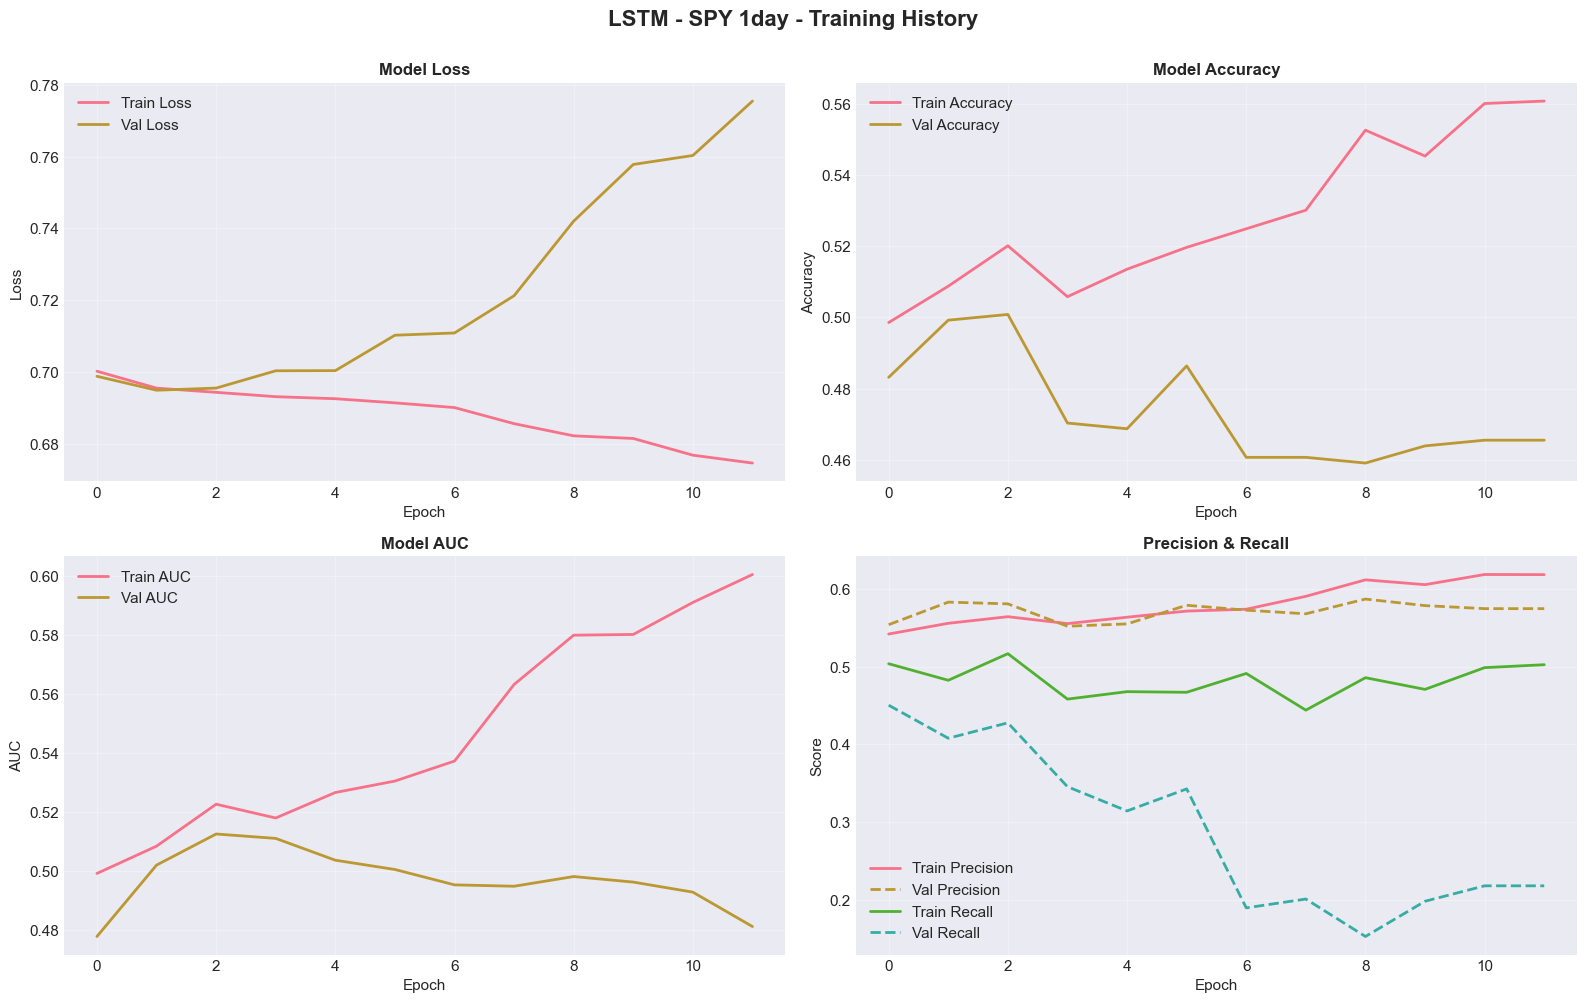


Training: SPY - 1week
Data loaded: Train=4382, Val=600, Test=1231
Data loaded: Train=4382, Val=600, Test=1231



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

[OK] Completed in 111.5s
  Accuracy: 0.4411
  F1 Score: 0.2339
  AUC: 0.5217

[OK] Completed in 111.5s
  Accuracy: 0.4411
  F1 Score: 0.2339
  AUC: 0.5217


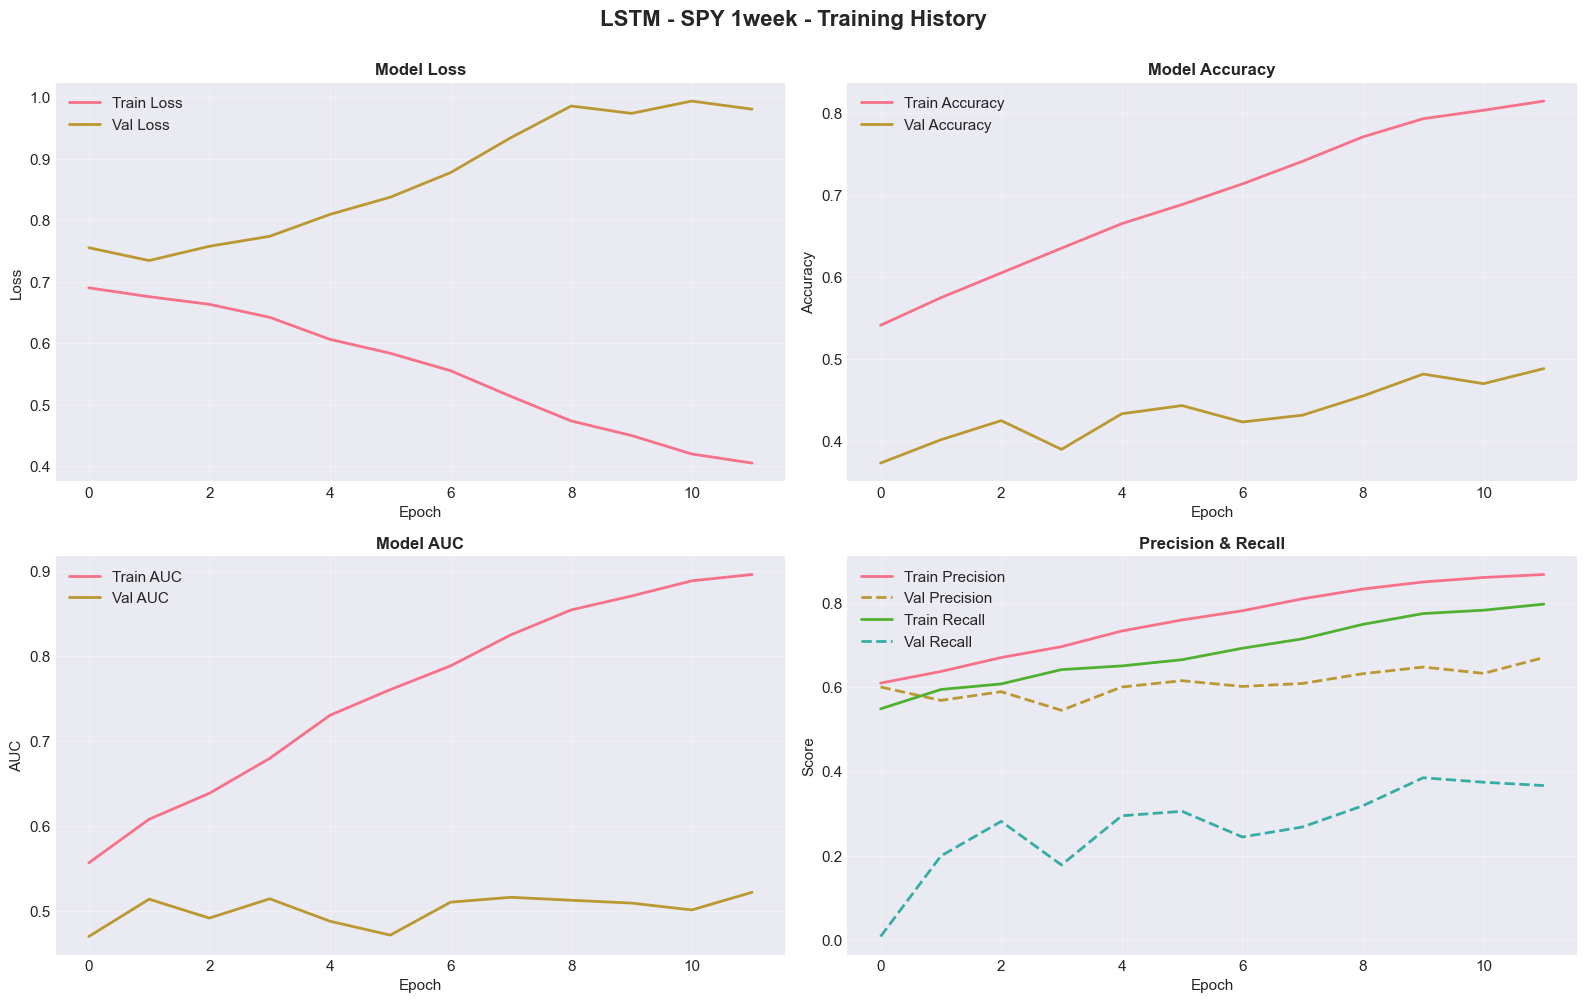


Training: SPY - 1month
Data loaded: Train=4322, Val=540, Test=1171
Data loaded: Train=4322, Val=540, Test=1171



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Restoring model weights from the end of the best epoch: 3.

[OK] Completed in 18068.7s
  Accuracy: 0.4142
  F1 Score: 0.3057
  AUC: 0.5092

[OK] Completed in 18068.7s
  Accuracy: 0.4142
  F1 Score: 0.3057
  AUC: 0.5092


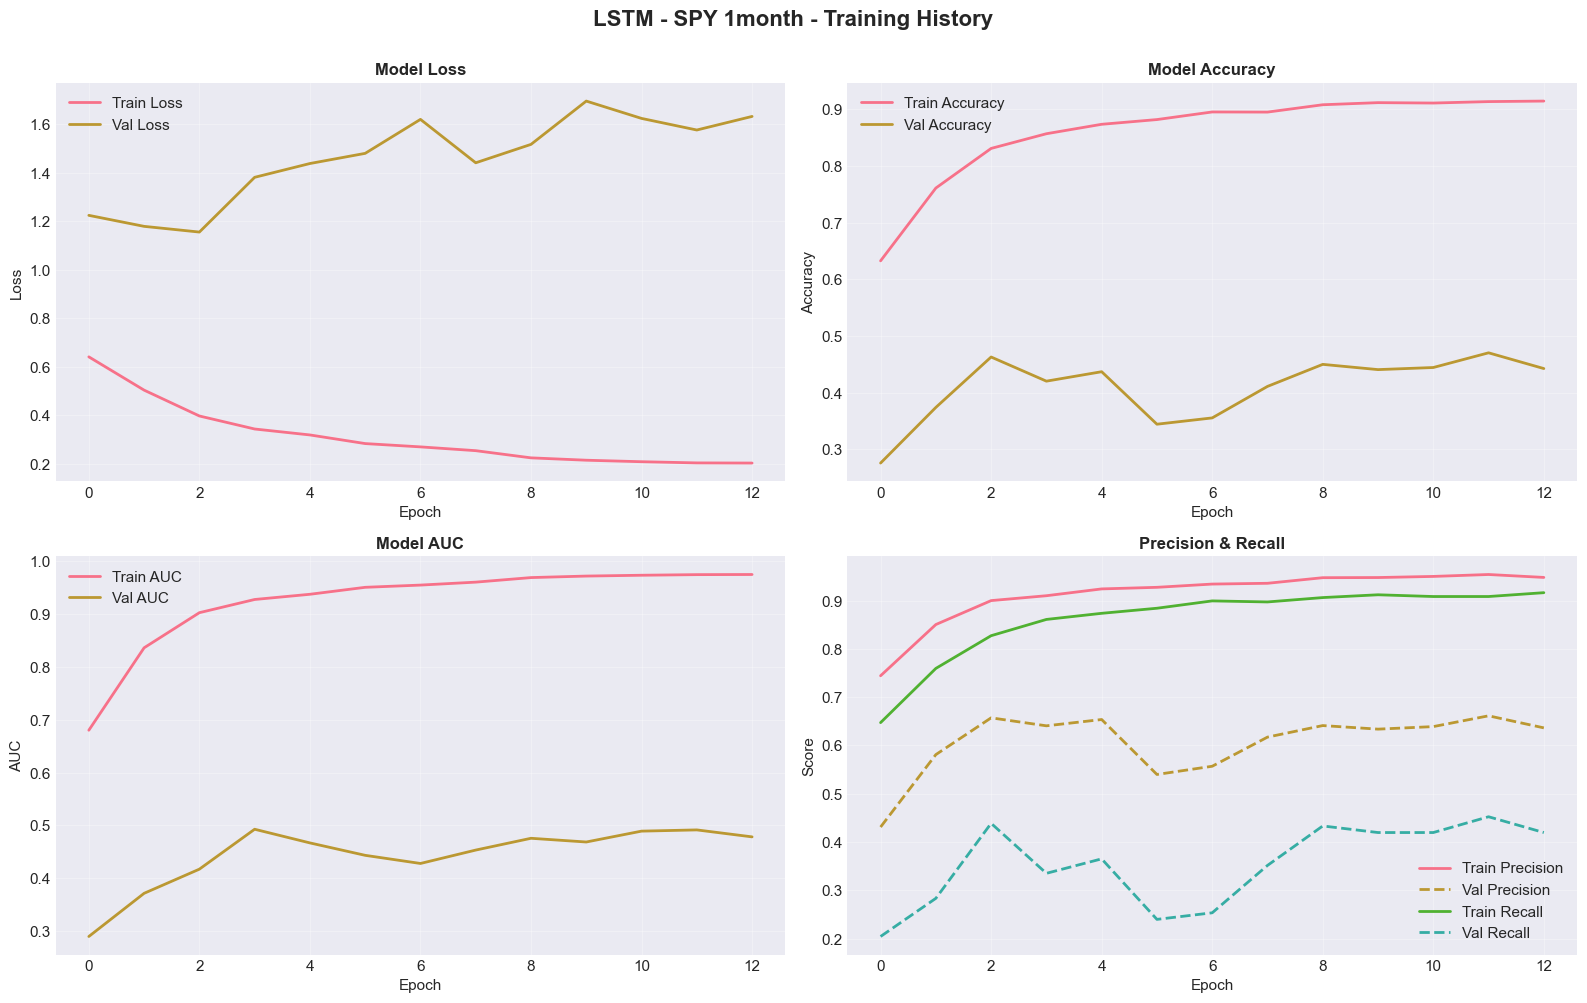


Training: BTC-USD - 1day
Data loaded: Train=2703, Val=380, Test=768



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

[OK] Completed in 48.5s
  Accuracy: 0.4974
  F1 Score: 0.2025
  AUC: 0.5310

[OK] Completed in 48.5s
  Accuracy: 0.4974
  F1 Score: 0.2025
  AUC: 0.5310


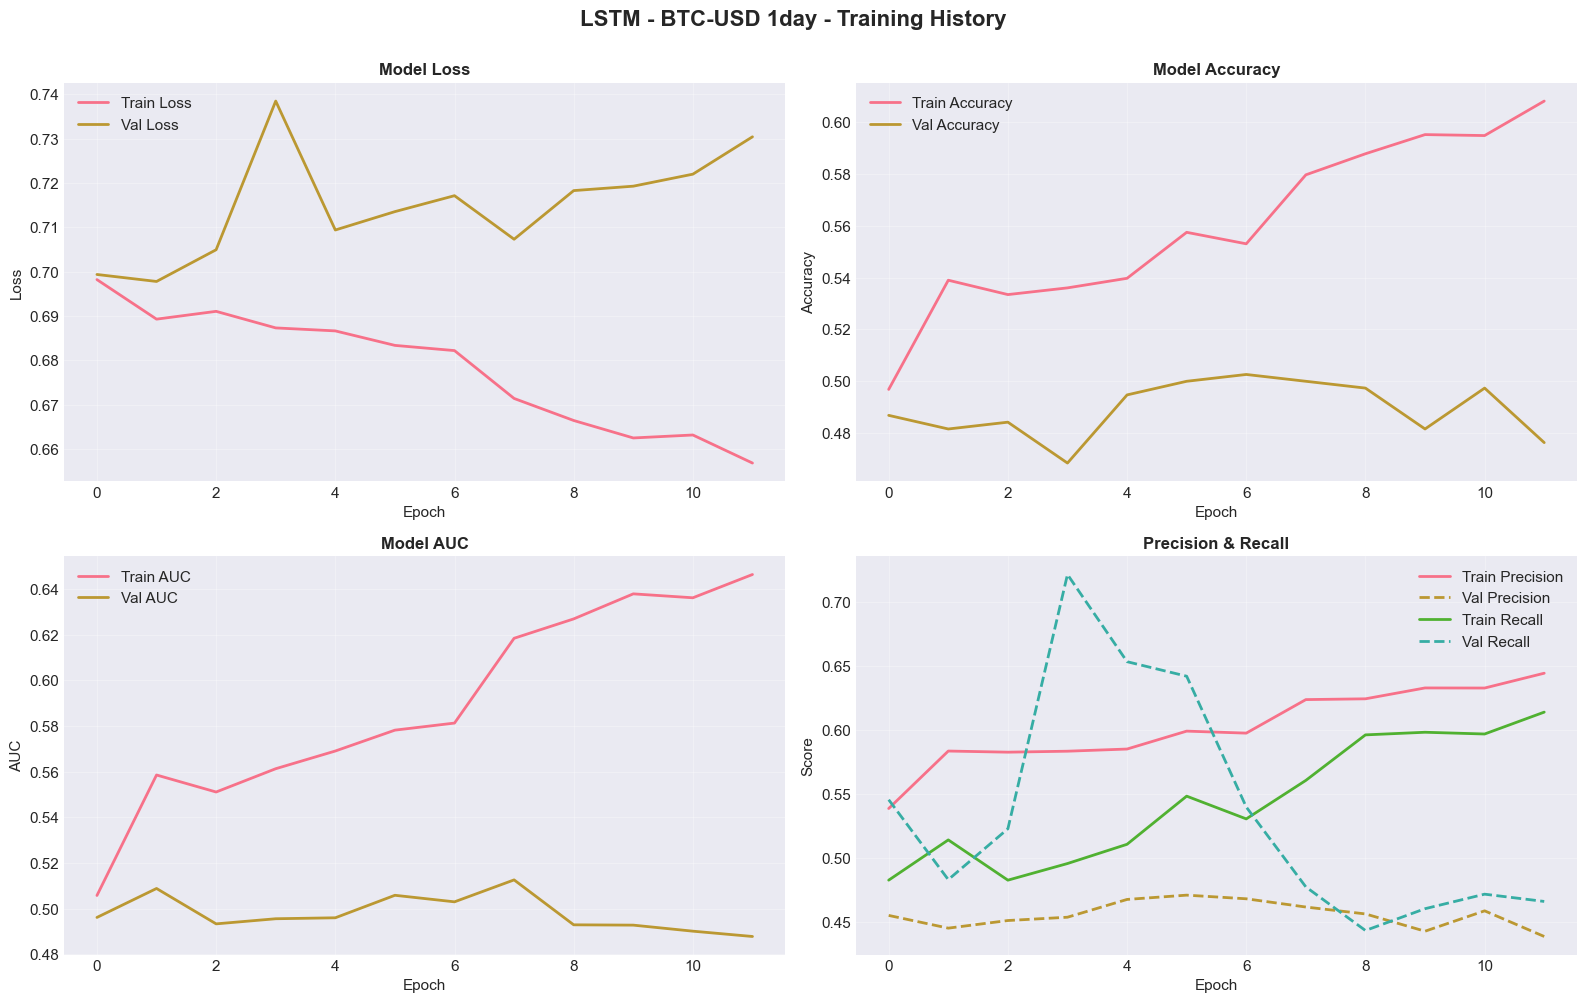


Training: BTC-USD - 1week
Data loaded: Train=2680, Val=357, Test=745
Data loaded: Train=2680, Val=357, Test=745



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 112.3s
  Accuracy: 0.4913
  F1 Score: 0.2583
  AUC: 0.5403

[OK] Completed in 112.3s
  Accuracy: 0.4913
  F1 Score: 0.2583
  AUC: 0.5403


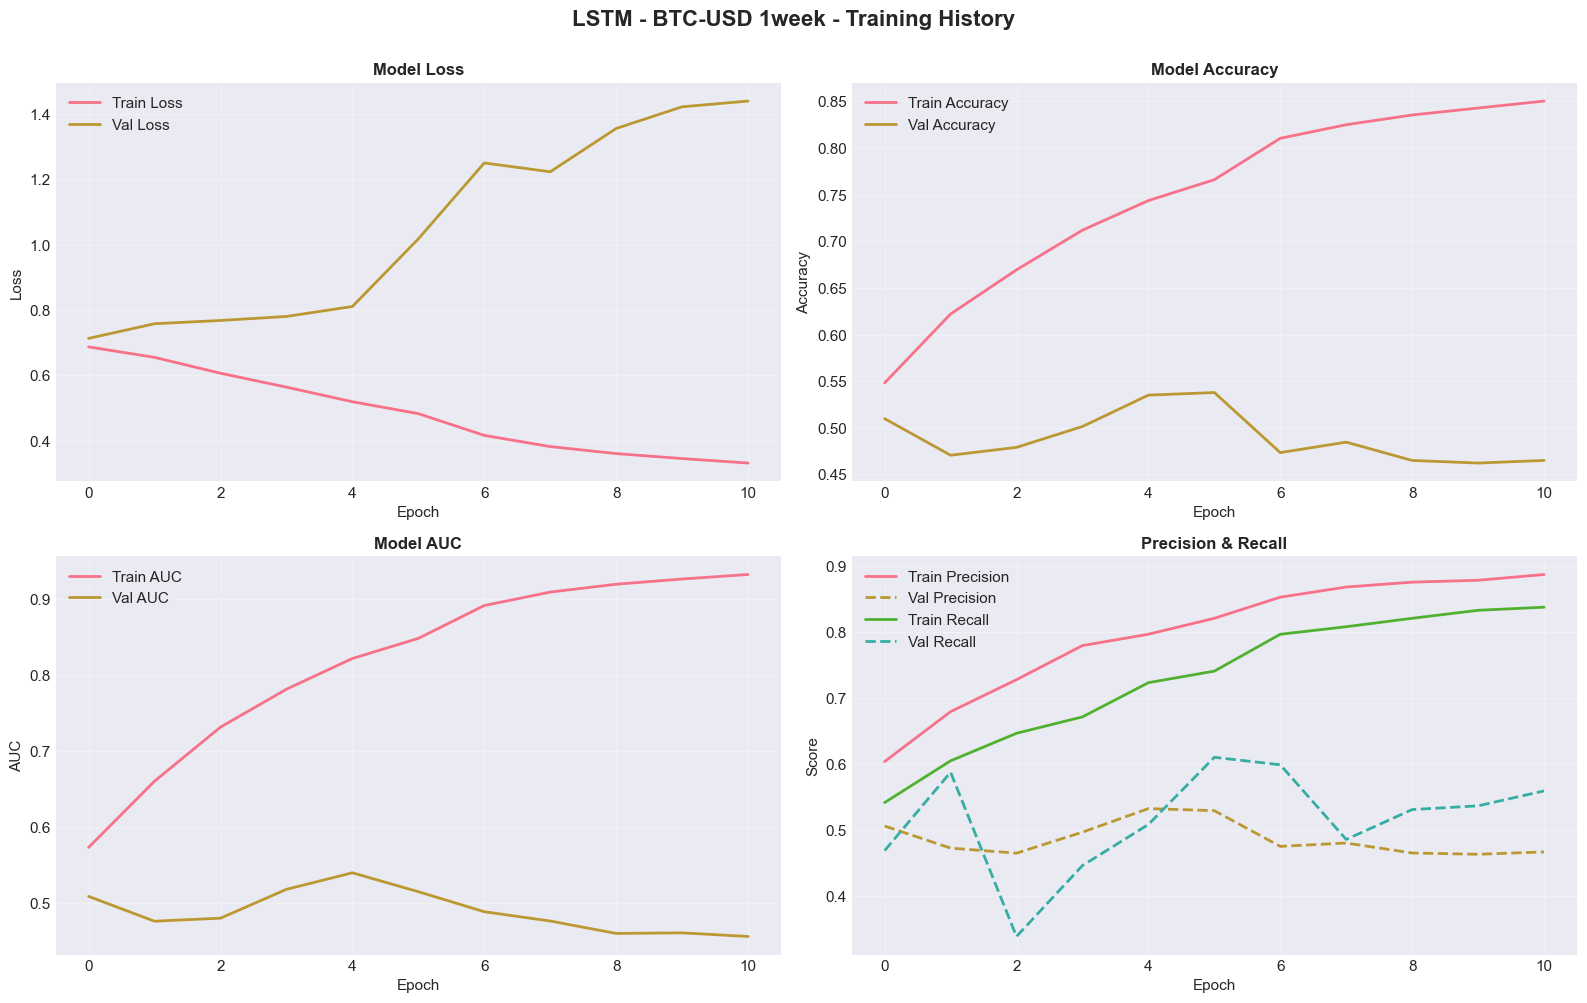


Training: BTC-USD - 1month
Data loaded: Train=2620, Val=297, Test=685
Data loaded: Train=2620, Val=297, Test=685



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 1.

[OK] Completed in 211.8s
  Accuracy: 0.4248
  F1 Score: 0.0483
  AUC: 0.4825

[OK] Completed in 211.8s
  Accuracy: 0.4248
  F1 Score: 0.0483
  AUC: 0.4825


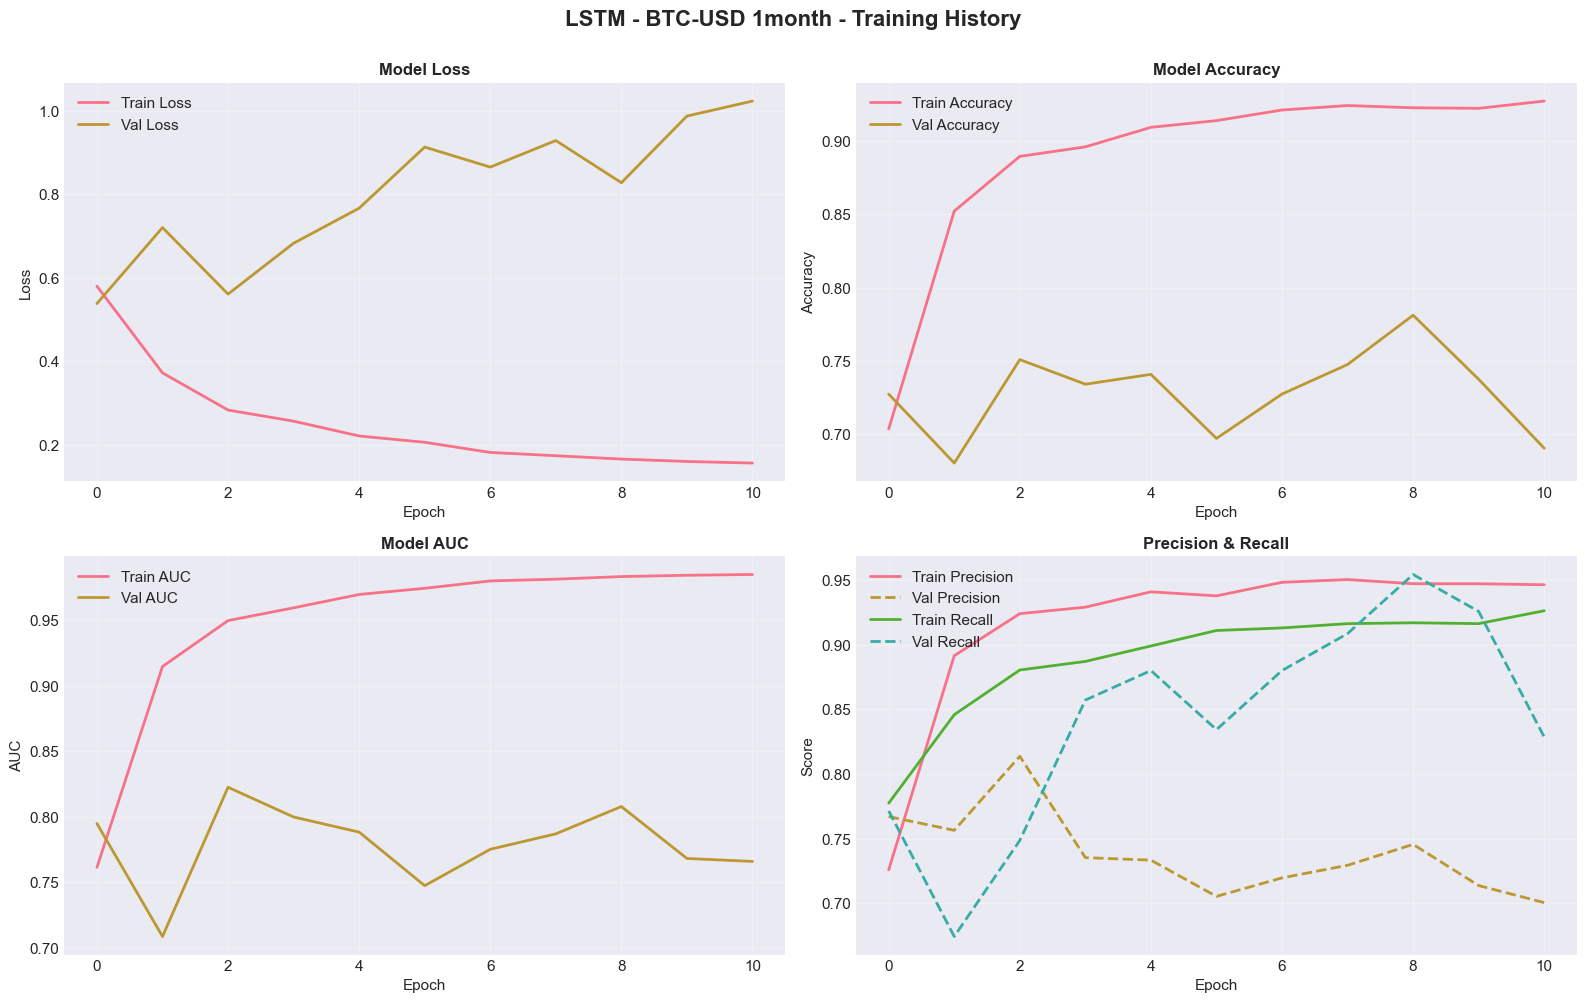


[OK] Complete LSTM training finished!


In [53]:
# Complete training loop
all_results = []
training_times = []

print("Starting complete LSTM training...")
print("="*80)

for asset in ASSETS:
    for horizon in HORIZONS:
        print(f"\n{'='*80}")
        print(f"Training: {asset} - {horizon}")
        print(f"{'='*80}")
        
        start_time = datetime.now()
        
        # Load data
        X_train, X_val, X_test, y_train, y_val, y_test, seq_len, n_feat = utils.load_sequences(asset, horizon)
        
        print(f"Data loaded: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")
        
        # Build model
        model = utils.build_lstm_model(
            sequence_length=seq_len,
            n_features=n_feat,
            lstm_units=128,
            lstm_layers=2,
            dropout_rate=0.3
        )
        
        # Get class weights
        cw = class_weights[asset][horizon]
        class_weight_dict = {0: cw[0], 1: cw[1]}
        
        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=utils.get_callbacks(f'LSTM_{asset}_{horizon}'),
            verbose=0
        )
        
        # Evaluate
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Calculate metrics
        result = {
            'asset': asset,
            'horizon': horizon,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'epochs_trained': len(history.history['loss']),
            'final_train_loss': history.history['loss'][-1],
            'final_val_loss': history.history['val_loss'][-1]
        }
        
        all_results.append(result)
        
        # Track training time
        elapsed = (datetime.now() - start_time).total_seconds()
        training_times.append({'asset': asset, 'horizon': horizon, 'time_seconds': elapsed})
        
        print(f"\n[OK] Completed in {elapsed:.1f}s")
        print(f"  Accuracy: {result['accuracy']:.4f}")
        print(f"  F1 Score: {result['f1']:.4f}")
        print(f"  AUC: {result['roc_auc']:.4f}")
        
        # Save training history plot
        utils.plot_training_history(
            history,
            f'LSTM - {asset} {horizon}',
            save_path=f'{FIGURES_DIR}LSTM_{asset}_{horizon}_history.png'
        )

print("\n" + "="*80)
print("[OK] Complete LSTM training finished!")
print("="*80)

## 6. Results Analysis

In [54]:
# Create results dataframe
lstm_results = pd.DataFrame(all_results)

# Save results
lstm_results.to_csv(f'{RESULTS_DIR}lstm_results_complete.csv', index=False)

print("LSTM Model Results - All Assets and Horizons:")
print("="*120)
print(lstm_results.to_string(index=False))

print(f"\n[OK] Results saved to {RESULTS_DIR}lstm_results_complete.csv")

LSTM Model Results - All Assets and Horizons:
  asset horizon  accuracy  precision   recall       f1  roc_auc  epochs_trained  final_train_loss  final_val_loss
   AAPL    1day  0.511962   0.544262 0.498498 0.520376 0.517570              12          0.664922        0.864839
   AAPL   1week  0.480910   0.562682 0.282991 0.376585 0.497543              11          0.374367        1.323640
   AAPL  1month  0.380871   0.421053 0.022253 0.042272 0.489649              11          0.212498        2.182982
   AMZN    1day  0.517544   0.516051 0.996899 0.680063 0.528741              11          0.672845        0.702574
   AMZN   1week  0.533712   0.533712 1.000000 0.695975 0.520036              13          0.372797        1.110187
   AMZN  1month  0.520068   0.586428 0.657102 0.619756 0.478464              11          0.186497        2.427577
   NVDA    1day  0.478469   0.518900 0.446746 0.480127 0.479195              20          0.568816        0.758971
   NVDA   1week  0.584078   0.584078 1.000

In [55]:
# Summary statistics
print("\n" + "="*80)
print("LSTM PERFORMANCE SUMMARY")
print("="*80)

print(f"\nOverall Statistics:")
print(f"  Mean Accuracy: {lstm_results['accuracy'].mean():.4f} ± {lstm_results['accuracy'].std():.4f}")
print(f"  Mean F1 Score: {lstm_results['f1'].mean():.4f} ± {lstm_results['f1'].std():.4f}")
print(f"  Mean ROC-AUC:  {lstm_results['roc_auc'].mean():.4f} ± {lstm_results['roc_auc'].std():.4f}")

print(f"\nBest Performance:")
best_idx = lstm_results['accuracy'].idxmax()
best = lstm_results.iloc[best_idx]
print(f"  {best['asset']} - {best['horizon']}")
print(f"  Accuracy: {best['accuracy']:.4f}")
print(f"  F1: {best['f1']:.4f}")

print(f"\nPerformance by Horizon:")
horizon_perf = lstm_results.groupby('horizon')[['accuracy', 'f1', 'roc_auc']].mean()
print(horizon_perf.round(4))

print(f"\nPerformance by Asset:")
asset_perf = lstm_results.groupby('asset')[['accuracy', 'f1', 'roc_auc']].mean()
print(asset_perf.round(4))


LSTM PERFORMANCE SUMMARY

Overall Statistics:
  Mean Accuracy: 0.4836 ± 0.0513
  Mean F1 Score: 0.4128 ± 0.2273
  Mean ROC-AUC:  0.4990 ± 0.0288

Best Performance:
  NVDA - 1week
  Accuracy: 0.5841
  F1: 0.7374

Performance by Horizon:
         accuracy      f1  roc_auc
horizon                           
1day       0.4987  0.4609   0.5099
1month     0.4459  0.3169   0.4793
1week      0.5062  0.4604   0.5079

Performance by Asset:
         accuracy      f1  roc_auc
asset                             
AAPL       0.4579  0.3131   0.5016
AMZN       0.5238  0.6653   0.5091
BTC-USD    0.4712  0.1697   0.5179
NVDA       0.5173  0.5954   0.4587
SPY        0.4478  0.3204   0.5079
         accuracy      f1  roc_auc
asset                             
AAPL       0.4579  0.3131   0.5016
AMZN       0.5238  0.6653   0.5091
BTC-USD    0.4712  0.1697   0.5179
NVDA       0.5173  0.5954   0.4587
SPY        0.4478  0.3204   0.5079


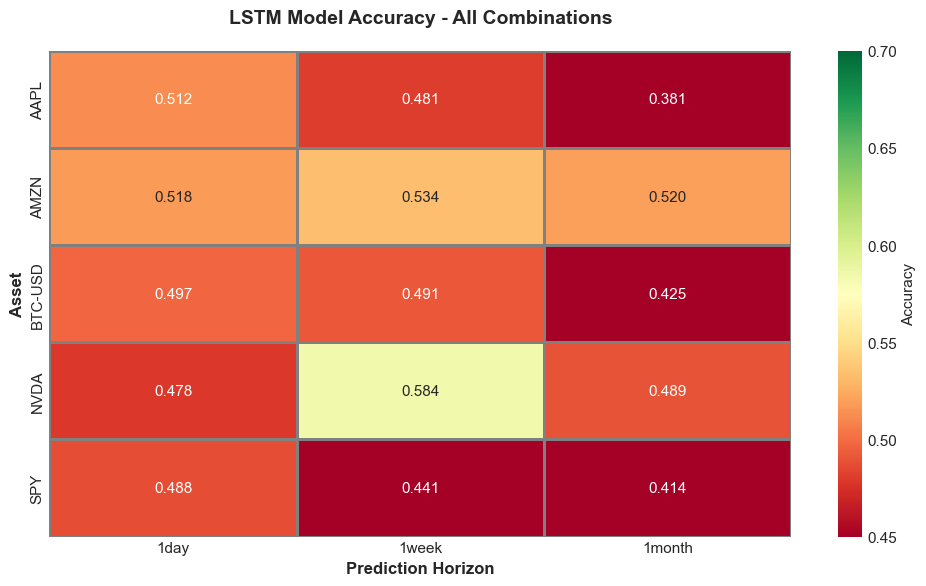

[OK] Accuracy heatmap saved


In [56]:
# Visualize: Accuracy heatmap
fig, ax = plt.subplots(figsize=(10, 6))

pivot_data = lstm_results.pivot(index='asset', columns='horizon', values='accuracy')
pivot_data = pivot_data[HORIZONS]  # Ensure correct order

sns.heatmap(
    pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
    vmin=0.45, vmax=0.70, cbar_kws={'label': 'Accuracy'},
    linewidths=1, linecolor='gray', ax=ax
)
ax.set_title('LSTM Model Accuracy - All Combinations', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Asset', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}lstm_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Accuracy heatmap saved")

In [57]:
# Compare with baselines
baseline_results = pd.read_csv(f'{RESULTS_DIR}baseline_results_complete.csv')

# Get best baseline for each asset-horizon
best_baselines = baseline_results.loc[
    baseline_results.groupby(['asset', 'horizon'])['accuracy'].idxmax()
].copy()
best_baselines['model_type'] = 'Best Baseline'

# Add LSTM results
lstm_for_comparison = lstm_results[['asset', 'horizon', 'accuracy', 'f1']].copy()
lstm_for_comparison['model_type'] = 'LSTM'

# Merge for comparison
comparison = pd.merge(
    lstm_for_comparison,
    best_baselines[['asset', 'horizon', 'accuracy', 'model']],
    on=['asset', 'horizon'],
    suffixes=('_lstm', '_baseline')
)
comparison['improvement'] = comparison['accuracy_lstm'] - comparison['accuracy_baseline']
comparison['improvement_pct'] = (comparison['improvement'] / comparison['accuracy_baseline'] * 100)

print("\n" + "="*120)
print("LSTM vs Best Baseline Comparison:")
print("="*120)
print(comparison[['asset', 'horizon', 'model', 'accuracy_baseline', 'accuracy_lstm', 'improvement', 'improvement_pct']].to_string(index=False))

print(f"\nAverage Improvement: {comparison['improvement'].mean():.4f} ({comparison['improvement_pct'].mean():.2f}%)")
print(f"LSTM wins: {(comparison['improvement'] > 0).sum()}/{len(comparison)} cases")

FileNotFoundError: [Errno 2] No such file or directory: '../results/baseline_results_complete.csv'

In [ ]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(comparison))
width = 0.35

bars1 = ax.bar(x - width/2, comparison['accuracy_baseline'], width, label='Best Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison['accuracy_lstm'], width, label='LSTM', alpha=0.8)

ax.set_xlabel('Asset - Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('LSTM vs Best Baseline Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['asset']}\n{row['horizon']}" for _, row in comparison.iterrows()], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}lstm_vs_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Comparison visualization saved")

## 7. Training Time Analysis

In [ ]:
# Analyze training times
times_df = pd.DataFrame(training_times)
times_df['time_minutes'] = times_df['time_seconds'] / 60

print("Training Time Analysis:")
print("="*80)
print(f"Total training time: {times_df['time_seconds'].sum()/3600:.2f} hours")
print(f"Average per model: {times_df['time_minutes'].mean():.2f} minutes")
print(f"\nBy Horizon:")
print(times_df.groupby('horizon')['time_minutes'].mean().round(2))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

pivot_times = times_df.pivot(index='asset', columns='horizon', values='time_minutes')
pivot_times = pivot_times[HORIZONS]

sns.heatmap(
    pivot_times, annot=True, fmt='.1f', cmap='YlOrRd',
    cbar_kws={'label': 'Training Time (minutes)'},
    linewidths=1, linecolor='gray', ax=ax
)
ax.set_title('LSTM Training Time (minutes)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Asset', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}lstm_training_times.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[OK] Training time analysis saved")